## SETUP

# About Dataset

**Content**

The DataCoSupplyChain Dataset is a comprehensive collection of structured and unstructured data that provides insights into the company DataCo Global's supply chain operations. It includes information on transactions, delivery times, product categories, and customer details. The structured data, contained in the DataCoSupplyChainDataset.csv file, consists of several key fields such as the type of transaction, actual and scheduled shipping days, benefit per order, sales per customer, delivery status, and a binary variable indicating late delivery risk. There are also fields for customer identification, including city, country, email, first and last names, and a masked customer key for privacy. The dataset also includes unstructured data in the form of clickstream logs, which can be valuable for understanding user interactions and behavior related to the supply chain.
The dataset consists of structured and unstructured data, allowing for the correlation of structured data with clickstream data for knowledge generation. It includes details about transactions, delivery status, customer information, and product categories.

Type Data :
- Structured Data : DataCoSupplyChainDataset.csv
- Unstructured Data : tokenized_access_logs.csv (Clickstream)
- Types of Products : Clothing , Sports , and Electronic Supplies


Data Dictionary:

**DataCoSupplyChainDataset**

| FIELDS|DESCRIPTION|
| --- | --- |
|Type|Type of transaction made|
|Days for shipping (real)|Actual shipping days of the purchased product|
|Days for shipment (scheduled)|Days of scheduled delivery of the purchased product|
|Benefit per order|Earnings per order placed|
|Sales per customer|Total sales per customer made per customer|
|Delivery Status|Delivery status of orders: Advance shipping , Late delivery , Shipping canceled , Shipping on time|
|Late_delivery_risk|Categorical variable that indicates if sending is late (1), it isnotlate (0).|
|Category Id|Product category code|
|Category Name|Description of the product category|
|Customer City|City where the customer made the purchase|
|Customer Country|Country where the customer made the purchase|
|Customer Email|Customer's email|
|Customer Fname|Customer name|
|Customer Id|Customer ID|
|Customer Lname|Customer lastname|
|Customer Password|Masked customer key|
|Customer Segment|Types of Customers: Consumer , Corporate , Home Office|
|Customer State|State to which the store where the purchase is registered belongs|
|Customer Street|Street to which the store where the purchase is registered belongs|
|Customer Zipcode|Customer Zipcode|
|Department Id|Department code of store|
|Department Name|Department name of store|
|Latitude|Latitude corresponding to location of store|
|Longitude|Longitude corresponding to location of store|
|Market|Market to where the order is delivered : Africa , Europe , LATAM ,Pacific Asia , USCA|
|Order City|Destination city of the order|
|Order Country|Destination country of the order|
|Order Customer Id|Customer order code|
|order date (DateOrders)|Date on which the order is made|
|Order Id|Order code|
|Order Item Cardprod Id|Product code generated through the RFID reader|
|Order Item Discount|Order item discount value|
|Order Item Discount Rate|Order item discount percentage|
|Order Item Id|Order item code|
|Order Item Product Price|Price of products without discount|
|Order Item Profit Ratio|Order Item Profit Ratio|
|Order Item Quantity|Number of products per order|
|Sales|Value in sales|
|Order Item Total|Total amount per order|
|Order Profit Per Order|Order Profit Per Order|
|Order Region|Region of the world where the order is delivered : Southeast Asia,SouthAsia,Oceania ,Eastern Asia, West Asia , West of USA , US Center , West Africa, Central Africa ,North Africa ,Western Europe ,Northern , Caribbean , South America ,East Africa ,Southern Europe , East of USA ,Canada ,Southern Africa , Central Asia , Europe , Central America, Eastern Europe , South of USA|
|Order State|State of the region where the order is delivered|
|Order Status|Order Status : COMPLETE , PENDING , CLOSED , PENDING_PAYMENT ,CANCELED ,PROCESSING ,SUSPECTED_FRAUD ,ON_HOLD ,PAYMENT_REVIEW|
|Product Card Id|Product code|
|Product Category Id|Product category code|
|Product Description|Product Description|
|Product Image|Link of visit and purchase of the product|
|Product Name|Product Name|
|Product Price|Product Price|
|Product Status|Status of the product stock :If it is 1 not available , 0 the productisavailable|
|Shipping date (DateOrders)|Exact date and time of shipment|
|Shipping Mode|The following shipping modes are presented : Standard Class , First Class , Second Class , Same Day|


---

# Objectives:

Explore and provide insights

Risk Assessment: Predict the likelihood of late delivery

In [1]:
# @title Pyspark Installation
# install PySpark
! pip install pyspark >& /dev/null
! pip install gdown

---

## Libraries

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as fn
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DoubleType, DateType, TimestampType
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
pd.set_option('display.max_columns', None)

---

In [4]:
# @title Download the data sets

!gdown 'https://drive.google.com/uc?export=download&id=1P1DmsJr66nq2zYv_XYoy6LeCa6-8ZVzT&confirm=t' -O data.zip
!unzip -o data.zip
!rm data.zip

Downloading...
From: https://drive.google.com/uc?export=download&id=1P1DmsJr66nq2zYv_XYoy6LeCa6-8ZVzT&confirm=t
To: /content/data.zip
100% 26.2M/26.2M [00:00<00:00, 39.1MB/s]
Archive:  data.zip
   creating: DATA/
  inflating: DATA/tokenized_access_logs.csv  
  inflating: DATA/DataCoSupplyChainDataset.csv  


---

In [5]:
# @title Directory

base_data_dir = r'/content/DATA'

---

In [6]:
# @title FUNCTIONS

def sdf_quick_display(sdf, n = 5):
  display(print(f'Number of Rows: {sdf.count()}'))
  display(sdf.show(5))
  display(sdf.printSchema())

def value_counts(sdf, column_name, sort_b = False):
  value_counts_df = sdf.groupby(column_name).count().toPandas().head(20).set_index(column_name).squeeze()
  value_counts_df = value_counts_df.sort_values(ascending = False)
  return value_counts_df

def plot_barh_chart(sdf, column_name, n = 10):
  value_counts_df = value_counts(sdf, column_name, False)
  total = value_counts_df.sum()
  percentage = (value_counts_df/ total) * 100

  # Plot
  plt.figure(figsize=(12,6))

  # Plot bar chart in descending order
  value_counts_df.sort_values(ascending=True).plot(kind='barh', y='count', color='skyblue')
  for i in range(len(value_counts_df)):
    plt.text(total/(n*100), i, f'{value_counts_df.iloc[-i-1]} ({percentage.iloc[-i-1]:.2f}%)', va='center', ha = 'left')

  plt.title(f'{column_name}')
  plt.xlabel('Number of Occurrences')
  plt.ylabel(column_name)
  plt.show()

  return value_counts_df


def plot_bar_chart(sdf, column_name, n = 10, order_cat = False):
  value_counts_df = value_counts(sdf, column_name, False)
  if order_cat:
    value_counts_df = value_counts_df.sort_index(ascending=True)
  total = value_counts_df.sum()
  percentage = (value_counts_df/ total) * 100

  # Plot
  plt.figure(figsize=(12,6))

  # Plot bar chart in descending order
  if order_cat:
    value_counts_df.sort_index(ascending=True).plot(kind='bar', y='count', color='skyblue')
  else:
    value_counts_df.sort_values(ascending=False).plot(kind='bar', y='count', color='skyblue')

  for i in range(len(value_counts_df)):
    plt.text(i, total/(n*100), f'{value_counts_df.iloc[-i-1]}\n({percentage.iloc[-i-1]:.2f}%)', va='bottom', ha = 'center')

  # Rotate x-axis labels
  plt.xticks(rotation=90)
  plt.title(f'{column_name}')
  plt.ylabel('Number of Occurrences')
  plt.xlabel(column_name)
  plt.show()

  return value_counts_df


def plot_pie_chart(sdf, column_name):
  value_counts_df = value_counts(sdf, column_name, False).reset_index()

  total = value_counts_df['count'].sum()
  percentage = (value_counts_df['count']/ total) * 100


  # Plot pie chart
  plt.figure(figsize=(8,8))
  plt.pie(value_counts_df['count'], labels=value_counts_df[column_name], autopct='%1.1f%%', startangle=140)
  plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
  plt.title(f'Pie Chart of {column_name}')
  # Show legend
  plt.legend(title=column_name, loc="best")

  plt.show()

  return value_counts_df

---

## Spark Session

In [7]:
# create Spark Session
spark = SparkSession.builder.appName('BDA-Project').getOrCreate()

---

## Loading Data

In [8]:
# DataCoSupplyChainDataset


data_dir =  os.path.join(base_data_dir, 'DataCoSupplyChainDataset.csv')

dataco_sdf = spark.read.csv(data_dir, header=True, inferSchema = True)#schema=schema)

dataco_sdf = dataco_sdf.withColumn("shipping date (DateOrders)", fn.to_timestamp("shipping date (DateOrders)", "M/d/yyyy H:mm"))
dataco_sdf = dataco_sdf.withColumn("order date (DateOrders)", fn.to_timestamp("order date (DateOrders)", "M/d/yyyy H:mm"))

# Display
sdf_quick_display(dataco_sdf)

Number of Rows: 180519


None

+--------+------------------------+-----------------------------+-----------------+------------------+----------------+------------------+-----------+--------------+-------------+----------------+--------------+--------------+-----------+--------------+-----------------+----------------+--------------+--------------------+----------------+-------------+---------------+-----------+------------+------------+----------+-------------+-----------------+-----------------------+--------+----------------------+-------------------+------------------------+-------------+------------------------+-----------------------+-------------------+------+----------------+----------------------+--------------+---------------+---------------+-------------+---------------+-------------------+-------------------+--------------------+------------+-------------+--------------+--------------------------+--------------+
|    Type|Days for shipping (real)|Days for shipment (scheduled)|Benefit per order|Sales per c

None

root
 |-- Type: string (nullable = true)
 |-- Days for shipping (real): integer (nullable = true)
 |-- Days for shipment (scheduled): integer (nullable = true)
 |-- Benefit per order: double (nullable = true)
 |-- Sales per customer: double (nullable = true)
 |-- Delivery Status: string (nullable = true)
 |-- Late_delivery_risk: integer (nullable = true)
 |-- Category Id: integer (nullable = true)
 |-- Category Name: string (nullable = true)
 |-- Customer City: string (nullable = true)
 |-- Customer Country: string (nullable = true)
 |-- Customer Email: string (nullable = true)
 |-- Customer Fname: string (nullable = true)
 |-- Customer Id: integer (nullable = true)
 |-- Customer Lname: string (nullable = true)
 |-- Customer Password: string (nullable = true)
 |-- Customer Segment: string (nullable = true)
 |-- Customer State: string (nullable = true)
 |-- Customer Street: string (nullable = true)
 |-- Customer Zipcode: integer (nullable = true)
 |-- Department Id: integer (nullable = 

None

In [9]:
# tokenized_access_logs
access_log_dir =  os.path.join(base_data_dir, 'tokenized_access_logs.csv')

access_log_sdf = spark.read.csv(access_log_dir, header=True, inferSchema = True)#, schema = schema)

# # Convert the "Date" column to a timestamp with the format 'M/d/yyyy H:mm'
access_log_sdf = access_log_sdf.withColumn("Date", fn.to_timestamp("Date", "M/d/yyyy H:mm"))

# Display
sdf_quick_display(access_log_sdf)

Number of Rows: 469977


None

+--------------------+-------------------+-------------------+-----+----+----------+--------------+--------------------+
|             Product|           Category|               Date|Month|Hour|Department|            ip|                 url|
+--------------------+-------------------+-------------------+-----+----+----------+--------------+--------------------+
|adidas Brazuca 20...|baseball & softball|2017-09-01 06:00:00|  Sep|   6|  fitness |  37.97.182.65|/department/fitne...|
|The North Face Wo...| hunting & shooting|2017-09-01 06:00:00|  Sep|   6| fan shop |  206.56.112.1|/department/fan%2...|
|adidas Kids' RG I...|     featured shops|2017-09-01 06:00:00|  Sep|   6|  apparel | 215.143.180.0|/department/appar...|
|Under Armour Men'...|        electronics|2017-09-01 06:00:00|  Sep|   6| footwear |  206.56.112.1|/department/footw...|
|Pelican Sunstream...|       water sports|2017-09-01 06:01:00|  Sep|   6| fan shop |136.108.56.242|/department/fan%2...|
+--------------------+----------

None

root
 |-- Product: string (nullable = true)
 |-- Category: string (nullable = true)
 |-- Date: timestamp (nullable = true)
 |-- Month: string (nullable = true)
 |-- Hour: integer (nullable = true)
 |-- Department: string (nullable = true)
 |-- ip: string (nullable = true)
 |-- url: string (nullable = true)



None

---

## Summary Statistics

In [10]:
dataco_sdf.describe().toPandas().head(20)

,summary,Type,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Delivery Status,Late_delivery_risk,Category Id,Category Name,Customer City,Customer Country,Customer Email,Customer Fname,Customer Id,Customer Lname,Customer Password,Customer Segment,Customer State,Customer Street,Customer Zipcode,Department Id,Department Name,Latitude,Longitude,Market,Order City,Order Country,Order Customer Id,Order Id,Order Item Cardprod Id,Order Item Discount,Order Item Discount Rate,Order Item Id,Order Item Product Price,Order Item Profit Ratio,Order Item Quantity,Sales,Order Item Total,Order Profit Per Order,Order Region,Order State,Order Status,Order Zipcode,Product Card Id,Product Category Id,Product Description,Product Image,Product Name,Product Price,Product Status,Shipping Mode
0,count,180519,180519,180519,180519,180519,180519,180519,180519,180519,180519,180519,180519,180519,180519,180511,180519,180519,180519,180519,180516,180519,180519,180519,180519,180519,180519,180519,180519,180519,180519,180519,180519,180519,180519,180519,180519,180519,180519,180519,180519,180519,180519,24840,180519,180519,0,180519,180519,180519,180519,180519
1,mean,None,3.4976539865609713,2.931846509231715,21.974988638593583,183.10760850780738,None,0.5482913155955883,31.85145053983237,None,None,None,None,None,6691.37949467923,None,None,None,94416.0,None,35921.12691395776,5.443460245181948,None,29.719954662073526,-84.9156746878377,None,None,None,6691.37949467923,36221.8949030296,692.5097635151978,20.664741121946605,0.10166819055205156,90260.0,141.23254992876335,0.12064663549029081,2.127637533999191,203.77209608624023,183.10760850780738,21.974988638593583,None,None,None,55426.13232689211,692.5097635151978,31.85145053983237,None,None,None,141.23254992876335,0.0,None
2,stddev,None,1.623721828374161,1.3744492800079773,104.43352574698625,120.04367002812536,None,0.49766386328809326,15.640063883389173,None,None,None,None,None,4162.918105728275,None,None,None,2324.4121837574335,None,37542.46112229264,1.6292460350717721,None,9.81364632692285,21.43324120028382,None,None,None,4162.918105728275,21045.37956885943,336.44680733022005,21.800900954295965,0.0704152153254764,52111.49095928847,139.732492003743,0.4667956046074952,1.453451481422638,132.2730774997035,120.04367002812536,104.43352574698625,None,None,None,31919.279100725274,336.44680733022005,15.640063883389173,None,None,None,139.732492003743,0.0,None
3,min,CASH,0,0,-4274.97998,7.489999771,Advance shipping,0,2,Accessories,Aguadilla,EE. UU.,XXXXXXXXX,Aaron,1,Abbott,XXXXXXXXX,Consumer,91732,1 Bright Manor,603,2,Apparel,-33.93755341,-158.0259857,Africa,Aachen,Afganist�n,1,1,19,0.0,0.0,1,9.989999771,-2.75,1,9.989999771,7.489999771,-4274.97998,Canada,Abia,CANCELED,1040,19,2,None,http://images.acmesports.sports/Adult+dog+supp...,Adult dog supplies,9.989999771,0,First Class
4,max,TRANSFER,6,4,911.7999878,1939.98999,Shipping on time,1,76,Women's Golf Clubs,Zanesville,Puerto Rico,XXXXXXXXX,Zorita,20757,Zuniga,XXXXXXXXX,Home Office,WV,Elk Grove,99205,12,Technology,48.78193283,115.2630768,USCA,�st� nad Labem,Zimbabue,20757,77204,1363,500.0,0.25,180519,1999.98999,0.5,5,1999.98999,1939.98999,911.7999878,Western Europe,�st� nad Labem,SUSPECTED_FRAUD,99301,1363,76,None,http://images.acmesports.sports/insta-bed+Neve...,insta-bed Neverflat Air Mattress,1999.98999,0,Standard Class


In [11]:
access_log_sdf.describe().toPandas().head(20)

,summary,Product,Category,Month,Hour,Department,ip,url
0,count,469977,469977,469977,469977,469977,469977,469977
1,mean,None,None,None,14.591826834079114,None,None,None
2,stddev,None,None,None,5.5740143669327304,None,None,None
3,min,Bag Boy Beverage Holder,accessories,Dec,0,apparel,1.100.203.104,/department/apparel/category/cleats/product/Pe...
4,max,insta-bed Neverflat Air Mattress,women's golf clubs,Sep,23,outdoors,99.99.191.106,/department/outdoors/category/women's%20golf%2...


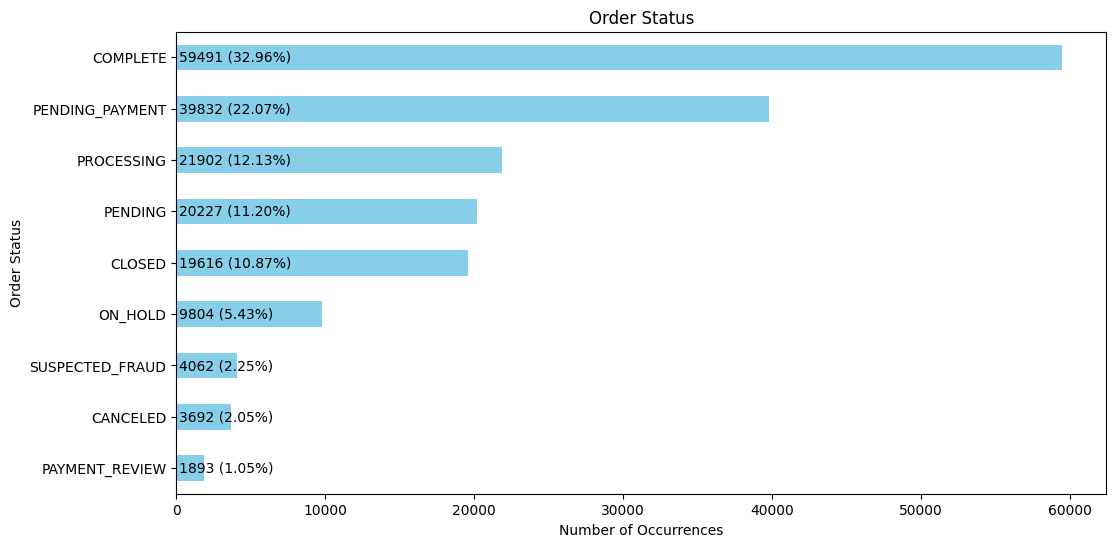

Order Status
COMPLETE           59491
PENDING_PAYMENT    39832
PROCESSING         21902
PENDING            20227
CLOSED             19616
ON_HOLD             9804
SUSPECTED_FRAUD     4062
CANCELED            3692
PAYMENT_REVIEW      1893
Name: count, dtype: int64

In [12]:
plot_barh_chart(dataco_sdf, 'Order Status')

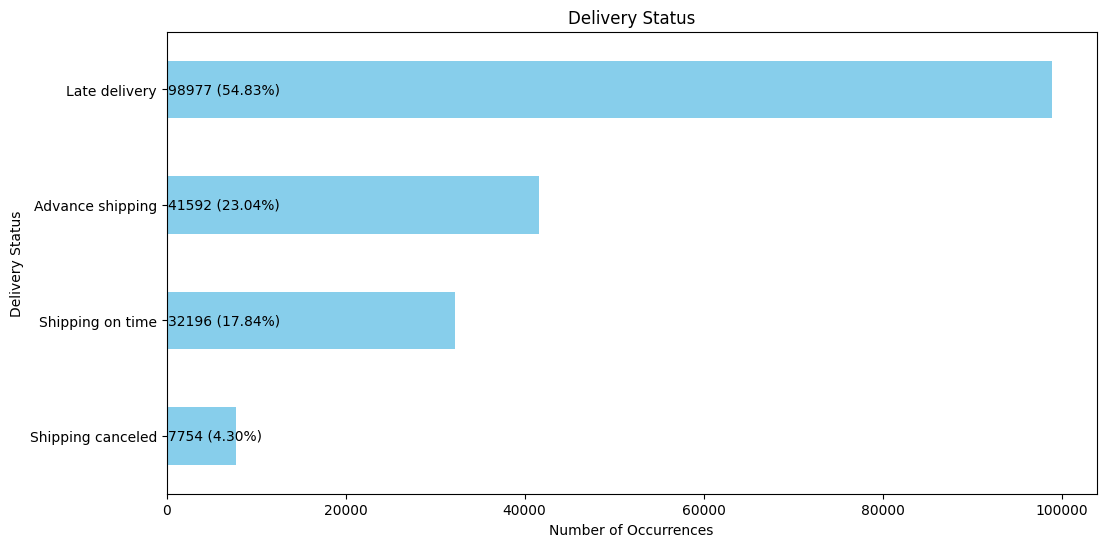

Delivery Status
Late delivery        98977
Advance shipping     41592
Shipping on time     32196
Shipping canceled     7754
Name: count, dtype: int64

In [13]:
plot_barh_chart(dataco_sdf, 'Delivery Status')

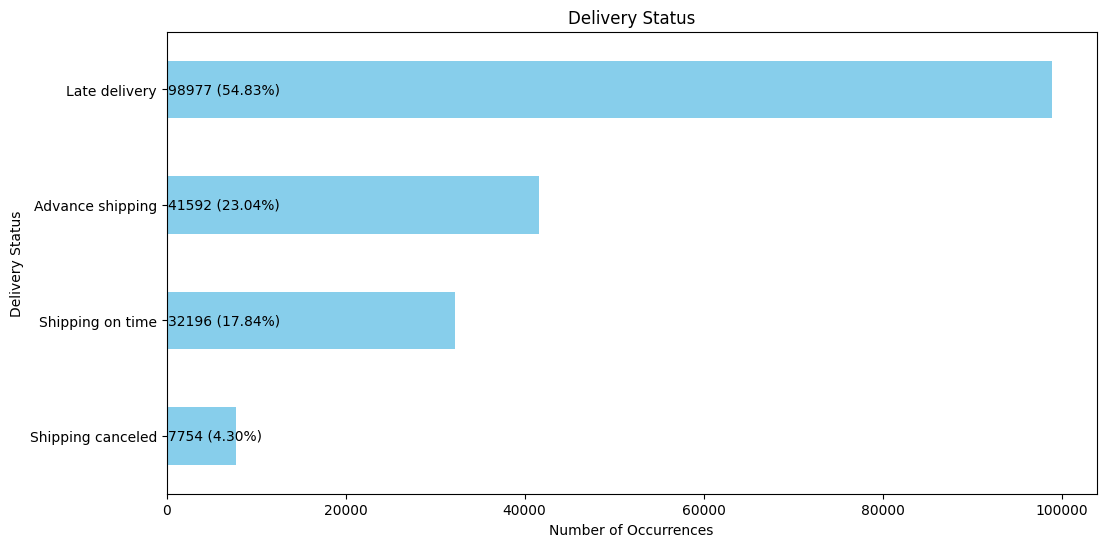

Delivery Status
Late delivery        98977
Advance shipping     41592
Shipping on time     32196
Shipping canceled     7754
Name: count, dtype: int64

In [14]:
plot_barh_chart(dataco_sdf, 'Delivery Status')

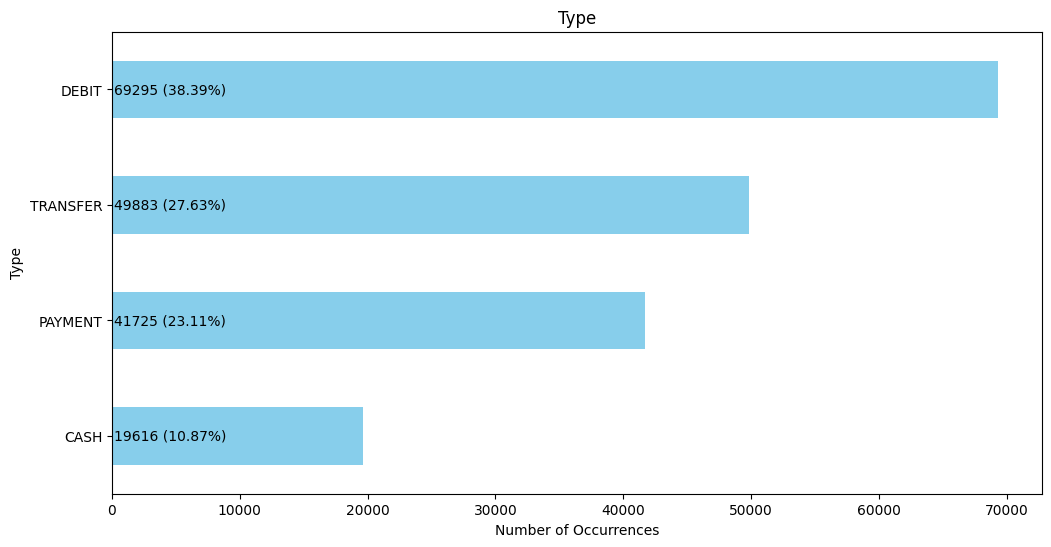

Type
DEBIT       69295
TRANSFER    49883
PAYMENT     41725
CASH        19616
Name: count, dtype: int64

In [15]:
plot_barh_chart(dataco_sdf, 'Type')

---

# Data Pre processing

In [16]:
# @title handeling missing values


# Count the number of missing values in each column
missing_counts_sdf = dataco_sdf.select([fn.sum(fn.col(c).isNull().cast("int")).alias(c) for c in dataco_sdf.columns])

# as this is a summary we can bring it to pandas
missing_counts_df = missing_counts_sdf.toPandas()

# Transpose
missing_counts_df = missing_counts_df.T

# only columns with missing values
missing_counts_df = missing_counts_df[missing_counts_df>0]
missing_counts_df = missing_counts_df.reset_index().dropna().rename(columns={"index": "column", 0: "missing_count"}).reset_index(drop = True)

# Show the missing value counts
display(missing_counts_df)

,column,missing_count
0,Customer Lname,8.0
1,Customer Zipcode,3.0
2,Order Zipcode,155679.0
3,Product Description,180519.0


In [17]:
# @title Hadeling missing data
data_1_sdf = dataco_sdf

# Dropping records where Customer Zipcode is missing
data_1_sdf = data_1_sdf.filter(fn.col('Customer Zipcode').isNotNull())

#Fill missing in Customer Zipcode
data_1_sdf = data_1_sdf.withColumn('Order Zipcode', fn.when(fn.col('Order Zipcode').isNull(), 0).otherwise(fn.col('Order Zipcode')))


In [18]:
# @title Checking


# Count the number of missing values in each column
missing_counts_sdf = data_1_sdf.select([fn.sum(fn.col(c).isNull().cast("int")).alias(c) for c in dataco_sdf.columns])

# as this is a summary we can bring it to pandas
missing_counts_df = missing_counts_sdf.toPandas()

# Transpose
missing_counts_df = missing_counts_df.T

# only columns with missing values
missing_counts_df = missing_counts_df[missing_counts_df>0]
missing_counts_df = missing_counts_df.reset_index().dropna().rename(columns={"index": "column", 0: "missing_count"}).reset_index(drop = True)

# Show the missing value counts
display(missing_counts_df)

,column,missing_count
0,Customer Lname,8.0
1,Product Description,180516.0


In [19]:
# [f", '{col}': '{str(col).lower().replace(' ','_').replace('customer','cust')}'" for col in data_1_sdf.columns]

Customer Lname, Customer Zipcode,	Order Zipcode, and Product Description
have missing vlaues

In [20]:
# @title Data Pre Processing

# only keeping required columns
col_l = ['Type'
        , 'Days for shipping (real)'
        , 'Days for shipment (scheduled)'
        , 'Benefit per order'
        , 'Sales per customer'
        # , 'Delivery Status'
        , 'Late_delivery_risk'
        # , 'Category Id'
        , 'Category Name'
        , 'Customer City'
        , 'Customer Country'
        # , 'Customer Email'
        # , 'Customer Fname'
        # , 'Customer Id'
        # , 'Customer Lname'
        # , 'Customer Password'
        , 'Customer Segment'
        , 'Customer State'
        , 'Customer Street'
        , 'Customer Zipcode'
        # , 'Department Id'
        , 'Department Name'
        , 'Latitude'
        , 'Longitude'
        , 'Market'
        , 'Order City'
        , 'Order Country'
        # , 'Order Customer Id'
        , 'order date (DateOrders)'
        # , 'Order Id'
        # , 'Order Item Cardprod Id'
        , 'Order Item Discount'
        , 'Order Item Discount Rate'
        # , 'Order Item Id'
        , 'Order Item Product Price'
        , 'Order Item Profit Ratio'
        , 'Order Item Quantity'
        , 'Sales'
        , 'Order Item Total'
        , 'Order Profit Per Order'
        , 'Order Region'
        , 'Order State'
        , 'Order Status'
        , 'Order Zipcode'
        # , 'Product Card Id'
        , 'Product Category Id'
        , 'Product Description'
        # , 'Product Image'
        # , 'Product Name'
        , 'Product Price'
        , 'Product Status'
        , 'shipping date (DateOrders)'
        , 'Shipping Mode'
        , 'late_days'
        , 'Late_delivery'
        ]

rename_dict={
    'Type': 'type'
        , 'Days for shipping (real)': 'real_days_for_shipping'
        , 'Days for shipment (scheduled)': 'scheduled_days_for_shipping'
        , 'Benefit per order': 'benefit_per_order'
        , 'Sales per customer': 'sales_per_customer'
        , 'Delivery Status': 'delivery_status'
        , 'Late_delivery_risk': 'late_delivery_risk'
        , 'Category Id': 'prod_cat_id'
        , 'Category Name': 'prod_cat_name'
        , 'Customer City': 'cust_city'
        , 'Customer Country': 'cust_country'
        , 'Customer Email': 'cust_email'
        , 'Customer Fname': 'cust_first_name'
        , 'Customer Id': 'cust_id'
        , 'Customer Lname': 'cust_last_name'
        , 'Customer Password': 'cust_password'
        , 'Customer Segment': 'cust_segment'
        , 'Customer State': 'cust_state'
        , 'Customer Street': 'cust_street'
        , 'Customer Zipcode': 'cust_zipcode'
        , 'Department Id': 'department_id'
        , 'Department Name': 'department_name'
        , 'Latitude': 'latitude'
        , 'Longitude': 'longitude'
        , 'Market': 'market'
        , 'Order City': 'order_city'
        , 'Order Country': 'order_country'
        , 'Order Customer Id': 'order_cust_id'
        , 'order date (DateOrders)': 'order_date'
        , 'Order Id': 'order_id'
        , 'Order Item Cardprod Id': 'order_item_cardprod_id'
        , 'Order Item Discount': 'order_item_discount'
        , 'Order Item Discount Rate': 'order_item_discount_rate'
        , 'Order Item Id': 'order_item_id'
        , 'Order Item Product Price': 'order_item_product_price'
        , 'Order Item Profit Ratio': 'order_item_profit_ratio'
        , 'Order Item Quantity': 'order_item_quantity'
        , 'Sales': 'sales'
        , 'Order Item Total': 'order_item_total'
        , 'Order Profit Per Order': 'order_profit_per_order'
        , 'Order Region': 'order_region'
        , 'Order State': 'order_state'
        , 'Order Status': 'order_status'
        , 'Order Zipcode': 'order_zipcode'
        , 'Product Card Id': 'product_card_id'
        , 'Product Category Id': 'product_category_id'
        , 'Product Description': 'product_description'
        , 'Product Image': 'product_image'
        , 'Product Name': 'product_name'
        , 'Product Price': 'product_price'
        , 'Product Status': 'product_status'
        , 'shipping date (DateOrders)': 'shipping_date'
        , 'Shipping Mode': 'shipping_mode'
}

rename_col_l = [rename_dict.get(col, col) for col in col_l]

# copy
data_2_sdf = data_1_sdf

# late days
data_2_sdf = data_2_sdf.withColumn('late_days', fn.col('Days for shipping (real)')-fn.col('Days for shipment (scheduled)')) # - fn.lit(1)) # Created class imbalance # more than 1 day then late
data_2_sdf = data_2_sdf.withColumn('Late_delivery', fn.when(fn.col('late_days') >= fn.lit(1), fn.lit('Late')).otherwise(fn.lit('Not Late')))
# only keeping required columns
data_2_sdf = data_2_sdf.select(*[x for x in col_l]).toDF(*[x for x in rename_col_l])
data_2_sdf.show(5)

+--------+----------------------+---------------------------+-----------------+------------------+------------------+--------------+-----------+------------+------------+----------+--------------------+------------+---------------+-----------+------------+------------+----------+-------------+-------------------+-------------------+------------------------+------------------------+-----------------------+-------------------+------+----------------+----------------------+--------------+---------------+---------------+-------------+-------------------+-------------------+-------------+--------------+-------------------+--------------+---------+-------------+
|    type|real_days_for_shipping|scheduled_days_for_shipping|benefit_per_order|sales_per_customer|late_delivery_risk| prod_cat_name|  cust_city|cust_country|cust_segment|cust_state|         cust_street|cust_zipcode|department_name|   latitude|   longitude|      market|order_city|order_country|         order_date|order_item_discount|o

In [21]:
data_1_sdf.select('Category Id', 'Category Name').distinct().show(1000)

+-----------+--------------------+
|Category Id|       Category Name|
+-----------+--------------------+
|         41|            Trade-In|
|         76|    Women's Clothing|
|         32|        Golf Apparel|
|         30|    Men's Golf Clubs|
|         69|   Health and Beauty|
|         26|      Girls' Apparel|
|          5|            Lacrosse|
|         73|      Sporting Goods|
|          9|    Cardio Equipment|
|         68|              Garden|
|         48|        Water Sports|
|         37|         Electronics|
|         60|               Baby |
|         29|       Shop By Sport|
|         74|                Toys|
|         10|   Strength Training|
|          6|    Tennis & Racquet|
|         66|              Crafts|
|         71|               Music|
|         45|             Fishing|
|         36|          Golf Balls|
|         70|      Men's Clothing|
|          3| Baseball & Softball|
|         63| Children's Clothing|
|         67|                DVDs|
|         31|  Women

---

In [23]:
# @title Date parsing
data_3_sdf = data_2_sdf

# order date
data_3_sdf = data_3_sdf.withColumn('order_year', fn.year('order_date'))
data_3_sdf = data_3_sdf.withColumn('order_month', fn.month('order_date'))
data_3_sdf = data_3_sdf.withColumn('order_day', fn.dayofweek('order_date'))
data_3_sdf = data_3_sdf.withColumn('order_hour', fn.hour('order_date'))

data_3_sdf.show(5)

+--------+----------------------+---------------------------+-----------------+------------------+------------------+--------------+-----------+------------+------------+----------+--------------------+------------+---------------+-----------+------------+------------+----------+-------------+-------------------+-------------------+------------------------+------------------------+-----------------------+-------------------+------+----------------+----------------------+--------------+---------------+---------------+-------------+-------------------+-------------------+-------------+--------------+-------------------+--------------+---------+-------------+----------+-----------+---------+----------+
|    type|real_days_for_shipping|scheduled_days_for_shipping|benefit_per_order|sales_per_customer|late_delivery_risk| prod_cat_name|  cust_city|cust_country|cust_segment|cust_state|         cust_street|cust_zipcode|department_name|   latitude|   longitude|      market|order_city|order_count

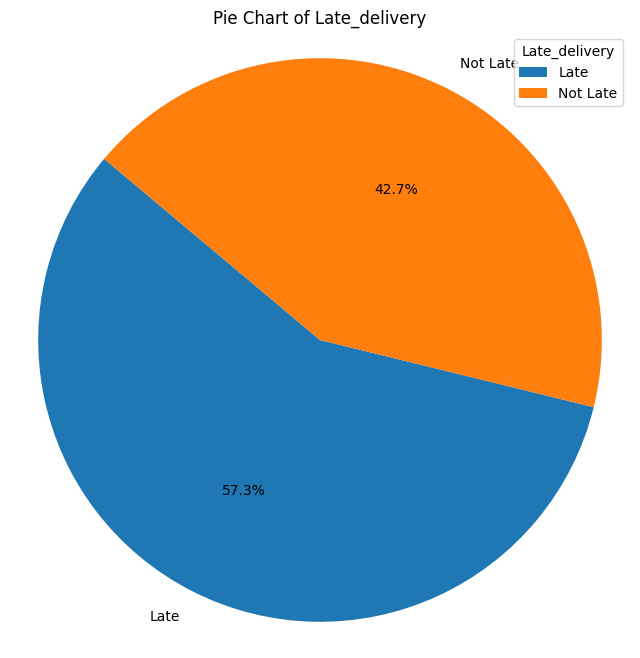

,Late_delivery,count
0,Late,103399
1,Not Late,77117


In [24]:
# @title Late Delivery

plot_pie_chart(data_3_sdf, 'Late_delivery')

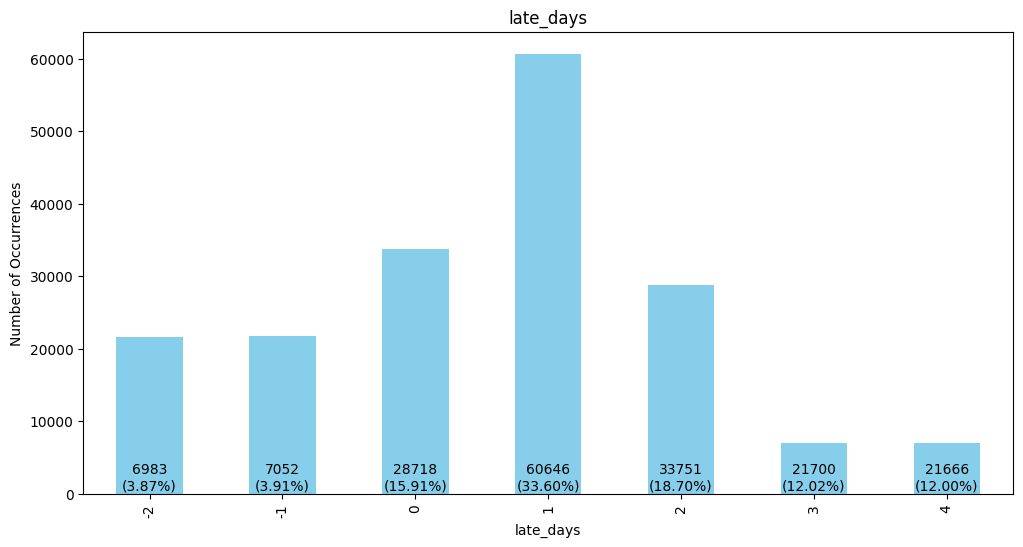

late_days
-2    21666
-1    21700
 0    33751
 1    60646
 2    28718
 3     7052
 4     6983
Name: count, dtype: int64

In [25]:
# @title Late Delivery Days

plot_bar_chart(data_3_sdf, 'late_days', order_cat = True)

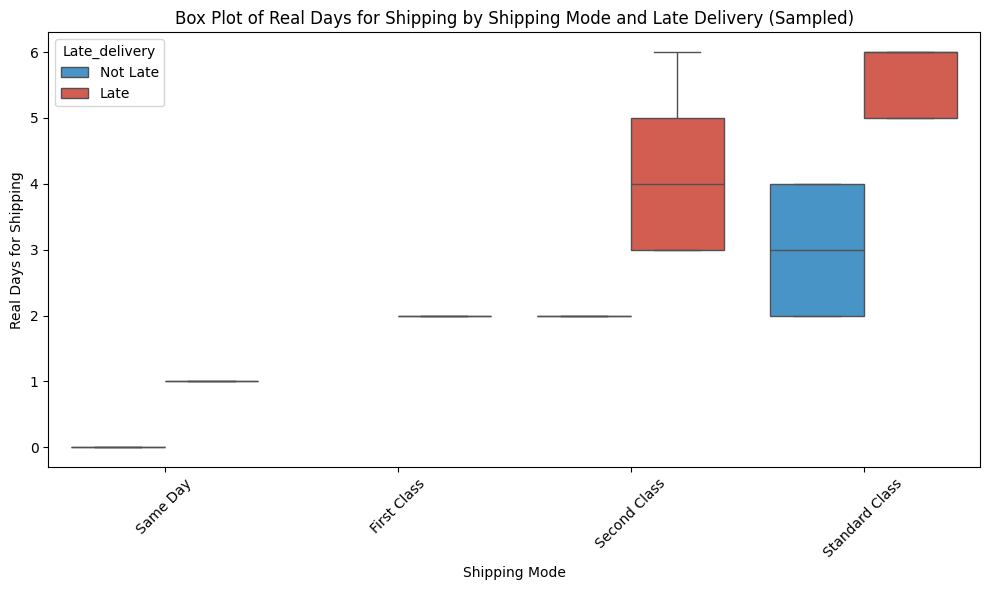

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

temp_sdf = data_3_sdf

# Take a sample of 1000 rows from the DataFrame
sample_sdf = temp_sdf.select('shipping_mode', 'Late_delivery', 'real_days_for_shipping').sample(False, .2)

# Convert the sampled DataFrame to Pandas DataFrame
sample_df = sample_sdf.toPandas()

# Order
shipping_mode_order = ['Same Day', 'First Class', 'Second Class', 'Standard Class']
# Define order and the palette with red for 'Late' and blue for 'Not Late'
hue_order = ['Not Late', 'Late']
hue_palette = {'Not Late': '#3498db', 'Late': '#e74c3c'}

# Plotting with Seaborn
plt.figure(figsize=(10, 6))
sns.boxplot(x='shipping_mode', y='real_days_for_shipping', hue='Late_delivery', order=shipping_mode_order, hue_order=hue_order, palette=hue_palette, data=sample_df)
plt.xlabel('Shipping Mode')
plt.ylabel('Real Days for Shipping')
plt.title('Box Plot of Real Days for Shipping by Shipping Mode and Late Delivery (Sampled)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [27]:
col_l = ['shipping_mode']

temp_sdf = data_3_sdf

# Calculate total count for each customer state
total_counts_df = temp_sdf.groupBy(col_l).count().withColumnRenamed('count', 'total_count')

# Group by count
temp_sdf = temp_sdf.groupby(col_l + ['Late_delivery']).agg(fn.count('*').alias('count'), fn.avg('late_days').alias('avg_late_days'))

# Order
shipping_mode_order = ['Same Day', 'First Class', 'Second Class', 'Standard Class']
# Define order and the palette with red for 'Late' and blue for 'Not Late'
hue_order = ['Not Late', 'Late']
hue_palette = {'Late': 'red', 'Not Late': 'blue'}

# Join total counts with the original data
temp_sdf = total_counts_df.join(temp_sdf, on=col_l, how = 'left').fillna(0)

# Calculate percentage of late delivery
temp_sdf = temp_sdf.withColumn('delivery_percentage', fn.col('count') / fn.col('total_count') * 100)

# Once data is summarized we can move to pandas to plot
temp_df = temp_sdf.select(*(col_l + ['Late_delivery', 'count', 'total_count', 'avg_late_days', 'delivery_percentage'])).toPandas()

# Fill missing values with 0
temp_df.fillna(0, inplace=True)

# Display
temp_df.head()

,shipping_mode,Late_delivery,count,total_count,avg_late_days,delivery_percentage
0,First Class,Late,27813,27813,1.000000,100.000000
1,Same Day,Late,4657,9737,1.000000,47.827873
2,Same Day,Not Late,5080,9737,0.000000,52.172127
3,Second Class,Late,28078,35216,2.496937,79.730804
4,Second Class,Not Late,7138,35216,0.000000,20.269196


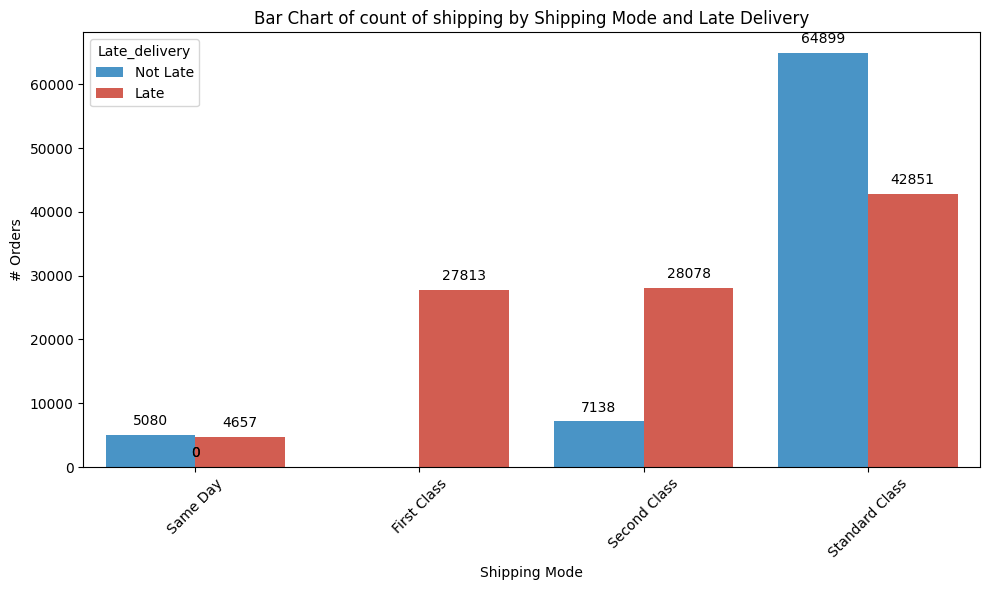

In [28]:
# Order
shipping_mode_order = ['Same Day', 'First Class', 'Second Class', 'Standard Class']
# Define order and the palette with red for 'Late' and blue for 'Not Late'
hue_order = ['Not Late', 'Late']
hue_palette = {'Not Late': '#3498db', 'Late': '#e74c3c'}

# Plotting with Seaborn
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='shipping_mode', y='count', hue='Late_delivery', order=shipping_mode_order, hue_order=hue_order, palette=hue_palette, data=temp_df)
plt.xlabel('Shipping Mode')
plt.ylabel('# Orders')
plt.title('Bar Chart of count of shipping by Shipping Mode and Late Delivery')
plt.xticks(rotation=45)
plt.tight_layout()

# Add labels on top of each bar
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.show()

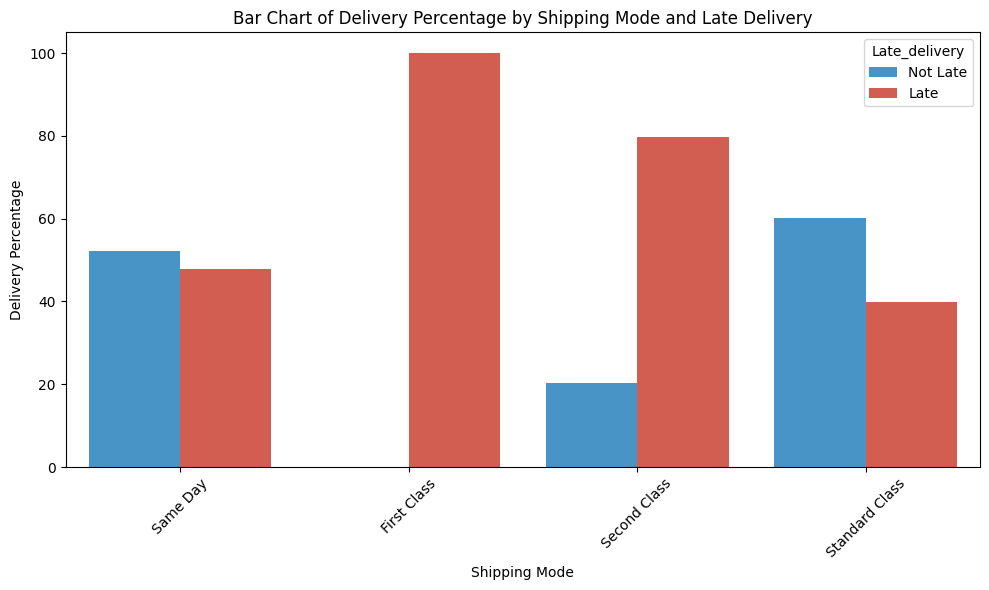

In [29]:
# Order
shipping_mode_order = ['Same Day', 'First Class', 'Second Class', 'Standard Class']
# Define order and the palette with red for 'Late' and blue for 'Not Late'
hue_order = ['Not Late', 'Late']
hue_palette = {'Not Late': '#3498db', 'Late': '#e74c3c'}

# Plotting with Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='shipping_mode', y='delivery_percentage', hue='Late_delivery', order=shipping_mode_order, hue_order=hue_order, palette=hue_palette, data=temp_df)
plt.xlabel('Shipping Mode')
plt.ylabel('Delivery Percentage')
plt.title('Bar Chart of Delivery Percentage by Shipping Mode and Late Delivery')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

---

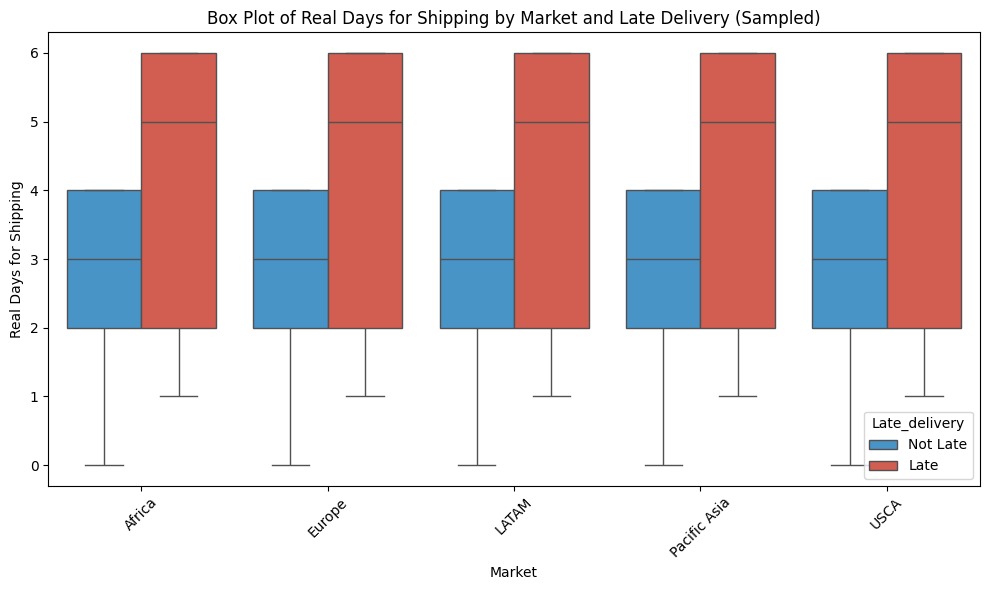

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

temp_sdf = data_3_sdf
col = 'Market'

# Take a sample of 1000 rows from the DataFrame
sample_sdf = temp_sdf.select(col, 'Late_delivery', 'real_days_for_shipping').sample(False, .2)

# Convert the sampled DataFrame to Pandas DataFrame
sample_df = sample_sdf.toPandas()

# Order
col_order = ['Africa' , 'Europe' , 'LATAM' ,'Pacific Asia' , 'USCA']
# Define order and the palette with red for 'Late' and blue for 'Not Late'
hue_order = ['Not Late', 'Late']
hue_palette = {'Not Late': '#3498db', 'Late': '#e74c3c'}

# Plotting with Seaborn
plt.figure(figsize=(10, 6))
sns.boxplot(x=col, y='real_days_for_shipping', hue='Late_delivery', order=col_order, hue_order=hue_order, palette=hue_palette, data=sample_df)
plt.xlabel(col)
plt.ylabel('Real Days for Shipping')
plt.title(f'Box Plot of Real Days for Shipping by {col} and Late Delivery (Sampled)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [31]:
col_l = ['Market']

temp_sdf = data_3_sdf

# Calculate total count for each customer state
total_counts_df = temp_sdf.groupBy(col_l).count().withColumnRenamed('count', 'total_count')

# Group by count
temp_sdf = temp_sdf.groupby(col_l + ['Late_delivery']).agg(fn.count('*').alias('count'), fn.avg('late_days').alias('avg_late_days'))

# Order
col_order = ['Africa' , 'Europe' , 'LATAM' ,'Pacific Asia' , 'USCA']
# Define order and the palette with red for 'Late' and blue for 'Not Late'
hue_order = ['Not Late', 'Late']
hue_palette = {'Late': 'red', 'Not Late': 'blue'}

# Join total counts with the original data
temp_sdf = total_counts_df.join(temp_sdf, on=col_l, how = 'left').fillna(0)

# Calculate percentage of late delivery
temp_sdf = temp_sdf.withColumn('delivery_percentage', fn.col('count') / fn.col('total_count') * 100)

# Once data is summarized we can move to pandas to plot
temp_df = temp_sdf.select(*(col_l + ['Late_delivery', 'count', 'total_count', 'avg_late_days', 'delivery_percentage'])).toPandas()

# Fill missing values with 0
temp_df.fillna(0, inplace=True)

# Display
temp_df.head()

,Market,Late_delivery,count,total_count,avg_late_days,delivery_percentage
0,Europe,Not Late,21262,50250,-0.854811,42.312438
1,Europe,Late,28988,50250,1.616531,57.687562
2,Africa,Late,6598,11614,1.601697,56.810746
3,Africa,Not Late,5016,11614,-0.810207,43.189254
4,Pacific Asia,Not Late,17610,41259,-0.844009,42.681597


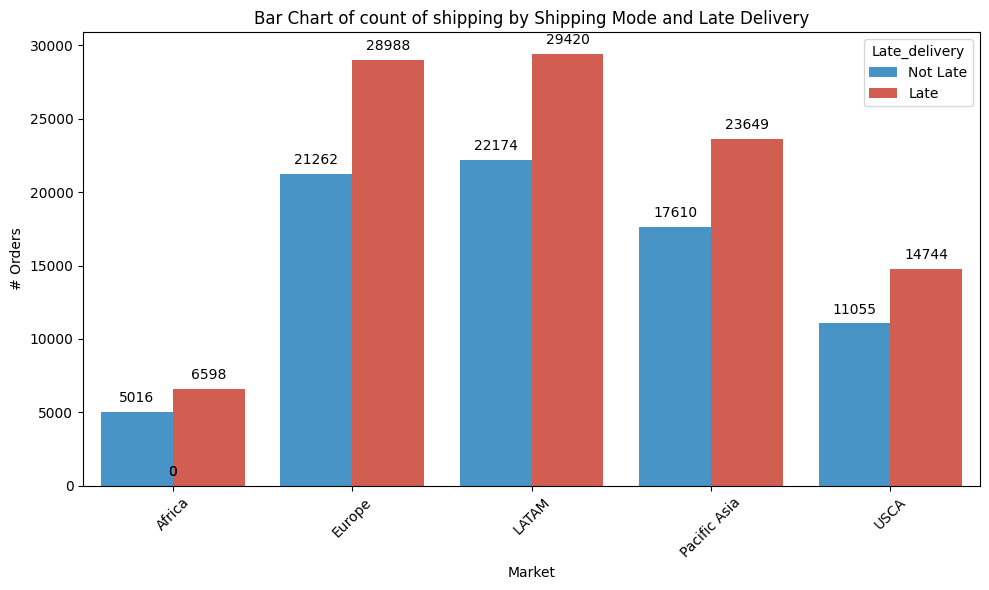

In [32]:
# Order
col_order = ['Africa' , 'Europe' , 'LATAM' ,'Pacific Asia' , 'USCA']
# Define order and the palette with red for 'Late' and blue for 'Not Late'
hue_order = ['Not Late', 'Late']
hue_palette = {'Not Late': '#3498db', 'Late': '#e74c3c'}

# Plotting with Seaborn
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=col, y='count', hue='Late_delivery', order=col_order, hue_order=hue_order, palette=hue_palette, data=temp_df)
plt.xlabel(col)
plt.ylabel('# Orders')
plt.title('Bar Chart of count of shipping by Shipping Mode and Late Delivery')
plt.xticks(rotation=45)
plt.tight_layout()

# Add labels on top of each bar
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.show()

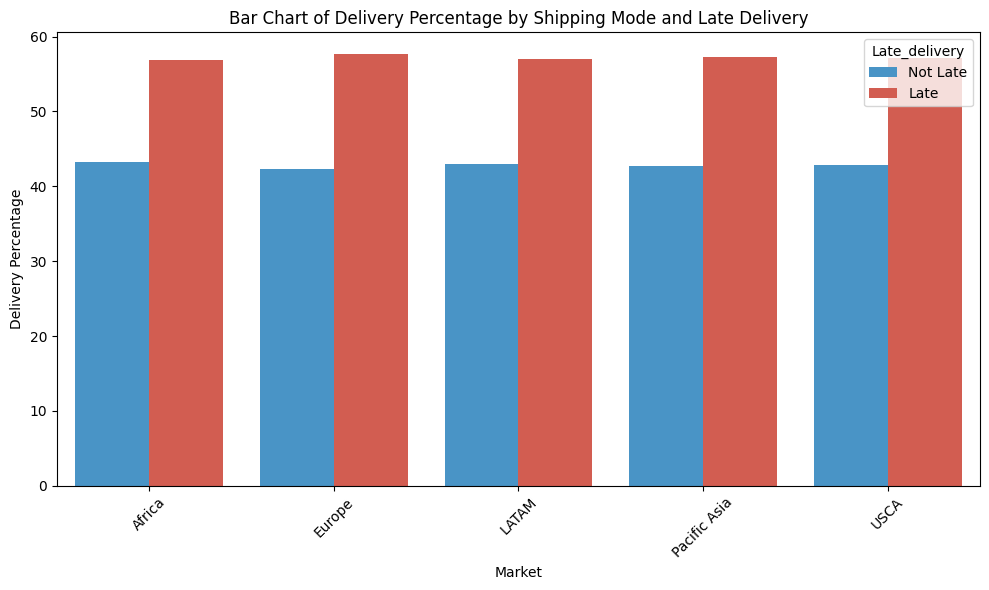

In [33]:
# Order
col_order = ['Africa' , 'Europe' , 'LATAM' ,'Pacific Asia' , 'USCA']
# Define order and the palette with red for 'Late' and blue for 'Not Late'
hue_order = ['Not Late', 'Late']
hue_palette = {'Not Late': '#3498db', 'Late': '#e74c3c'}

# Plotting with Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x=col, y='delivery_percentage', hue='Late_delivery', order=col_order, hue_order=hue_order, palette=hue_palette, data=temp_df)
plt.xlabel(col)
plt.ylabel('Delivery Percentage')
plt.title('Bar Chart of Delivery Percentage by Shipping Mode and Late Delivery')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

---

In [34]:
temp_sdf.head()

Row(Market='Europe', total_count=50250, Late_delivery='Not Late', count=21262, avg_late_days=-0.8548114006208258, delivery_percentage=42.312437810945276)

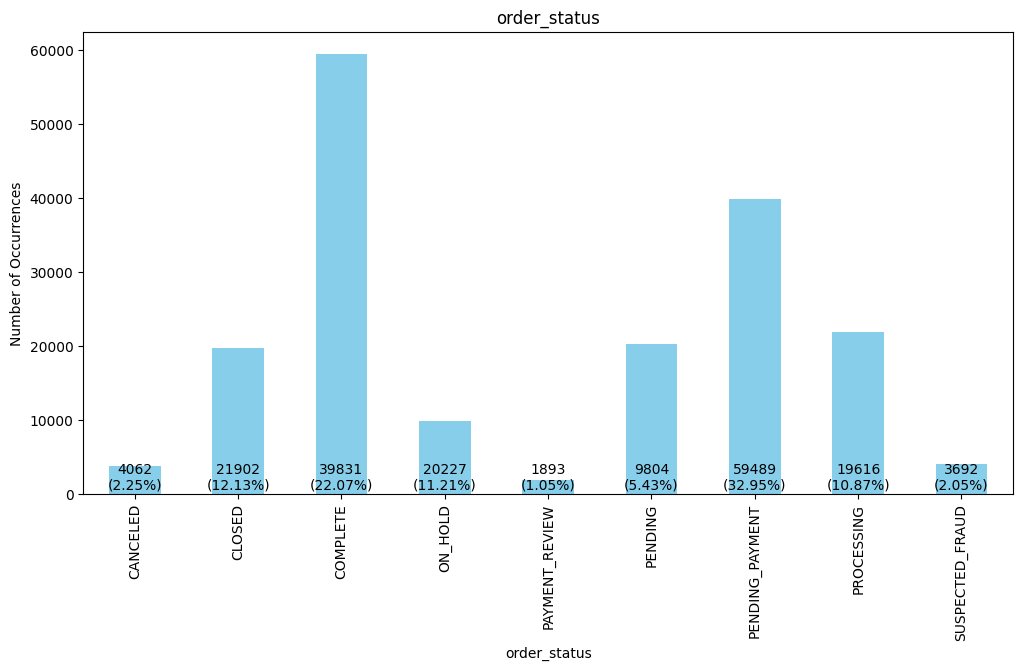

order_status
CANCELED            3692
CLOSED             19616
COMPLETE           59489
ON_HOLD             9804
PAYMENT_REVIEW      1893
PENDING            20227
PENDING_PAYMENT    39831
PROCESSING         21902
SUSPECTED_FRAUD     4062
Name: count, dtype: int64

In [39]:
# order_status
plot_bar_chart(data_3_sdf, 'order_status', order_cat = True)

---

# Analytics

In [40]:
data_3_sdf.printSchema()

root
 |-- type: string (nullable = true)
 |-- real_days_for_shipping: integer (nullable = true)
 |-- scheduled_days_for_shipping: integer (nullable = true)
 |-- benefit_per_order: double (nullable = true)
 |-- sales_per_customer: double (nullable = true)
 |-- late_delivery_risk: integer (nullable = true)
 |-- prod_cat_name: string (nullable = true)
 |-- cust_city: string (nullable = true)
 |-- cust_country: string (nullable = true)
 |-- cust_segment: string (nullable = true)
 |-- cust_state: string (nullable = true)
 |-- cust_street: string (nullable = true)
 |-- cust_zipcode: integer (nullable = true)
 |-- department_name: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- market: string (nullable = true)
 |-- order_city: string (nullable = true)
 |-- order_country: string (nullable = true)
 |-- order_date: timestamp (nullable = true)
 |-- order_item_discount: double (nullable = true)
 |-- order_item_discount_rate: double (nu

In [41]:
# Encode categorical variable

from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline

temp_data_sdf = data_3_sdf

col_l = temp_data_sdf.columns

y_col = 'Late_delivery'

columns_to_index = ['shipping_mode', 'cust_segment', 'Late_delivery']

index_order_dict = {'shipping_mode': ['Same Day', 'First Class', 'Standard Class', 'Second Class']
                    , 'cust_segment': ['Corporate', 'Home Office', 'Consumer']}

columns_to_encode = ['type'
                    , 'delivery_status'
                    , 'prod_cat_name'
                    , 'cust_city'
                    , 'cust_country'
                    , 'cust_segment'
                    , 'cust_state'
                    , 'cust_street'
                    , 'cust_zipcode'
                    , 'department_name'
                    , 'market'
                    , 'order_city'
                    , 'order_country'
                    , 'order_region'
                    , 'order_state'
                    , 'order_status'
                    , 'order_year'
                    # , 'order_month'
                    # , 'order_day'
                    # , 'order_hour'
                    # , 'shipping_mode'
                    ]

remove_col_l = ['order_date', 'shipping_date', 'product_description'
                  , 'longitude', 'latitude', 'late_days'
                  , 'product_status'
                  ]

remove_col_l = remove_col_l #+ [y_col]

columns_to_index = [col for col in columns_to_index if (col not in remove_col_l and col in col_l)]
columns_to_encode = [col for col in columns_to_encode if (col not in (remove_col_l + columns_to_index) and col in col_l)]

# Create a list of stages for the Pipeline
stages = []

# Iterate over each categorical column
for col in (columns_to_index + columns_to_encode):
  if col in remove_col_l:
    break
  else:
    # StringIndexer to convert categorical values to indices
    # if col in index_order_dict.keys():
    #   indexer = StringIndexer(inputCol=col, outputCol=f"{col}_index")
    # else:
    indexer = StringIndexer(inputCol=col, outputCol=f"{col}_index")
    stages += [indexer]
    if col in columns_to_encode:
      encoder = OneHotEncoder(inputCol=f"{col}_index", outputCol=f"{col}_encode", dropLast=False)
      stages += [encoder]



# Assemble all encoded features into a single vector
numeric_col_l = [col for col in col_l if col not in (columns_to_encode + columns_to_index + remove_col_l)]
indexed_col_l = [f"{col}_index" for col in columns_to_index]
encoded_col_l = [f"{col}_encode" for col in columns_to_encode]

assembler_inputs = numeric_col_l + [f"{col}_encode" for col in columns_to_encode]
assembler_inputs = numeric_col_l + indexed_col_l

vector_col = "features"
assembler = VectorAssembler(inputCols=assembler_inputs, outputCol=vector_col)
stages.append(assembler)

# Create the Pipeline
pipeline = Pipeline(stages=stages)

# Fit the Pipeline to the DataFrame
pipeline_model = pipeline.fit(temp_data_sdf)

# Transform the DataFrame
temp_data_sdf = pipeline_model.transform(temp_data_sdf)

vector_sdf = temp_data_sdf.select(vector_col)

# get correlation matrix
matrix = Correlation.corr(vector_sdf, vector_col)

# temp_data_sdf.show(5)

<Axes: >

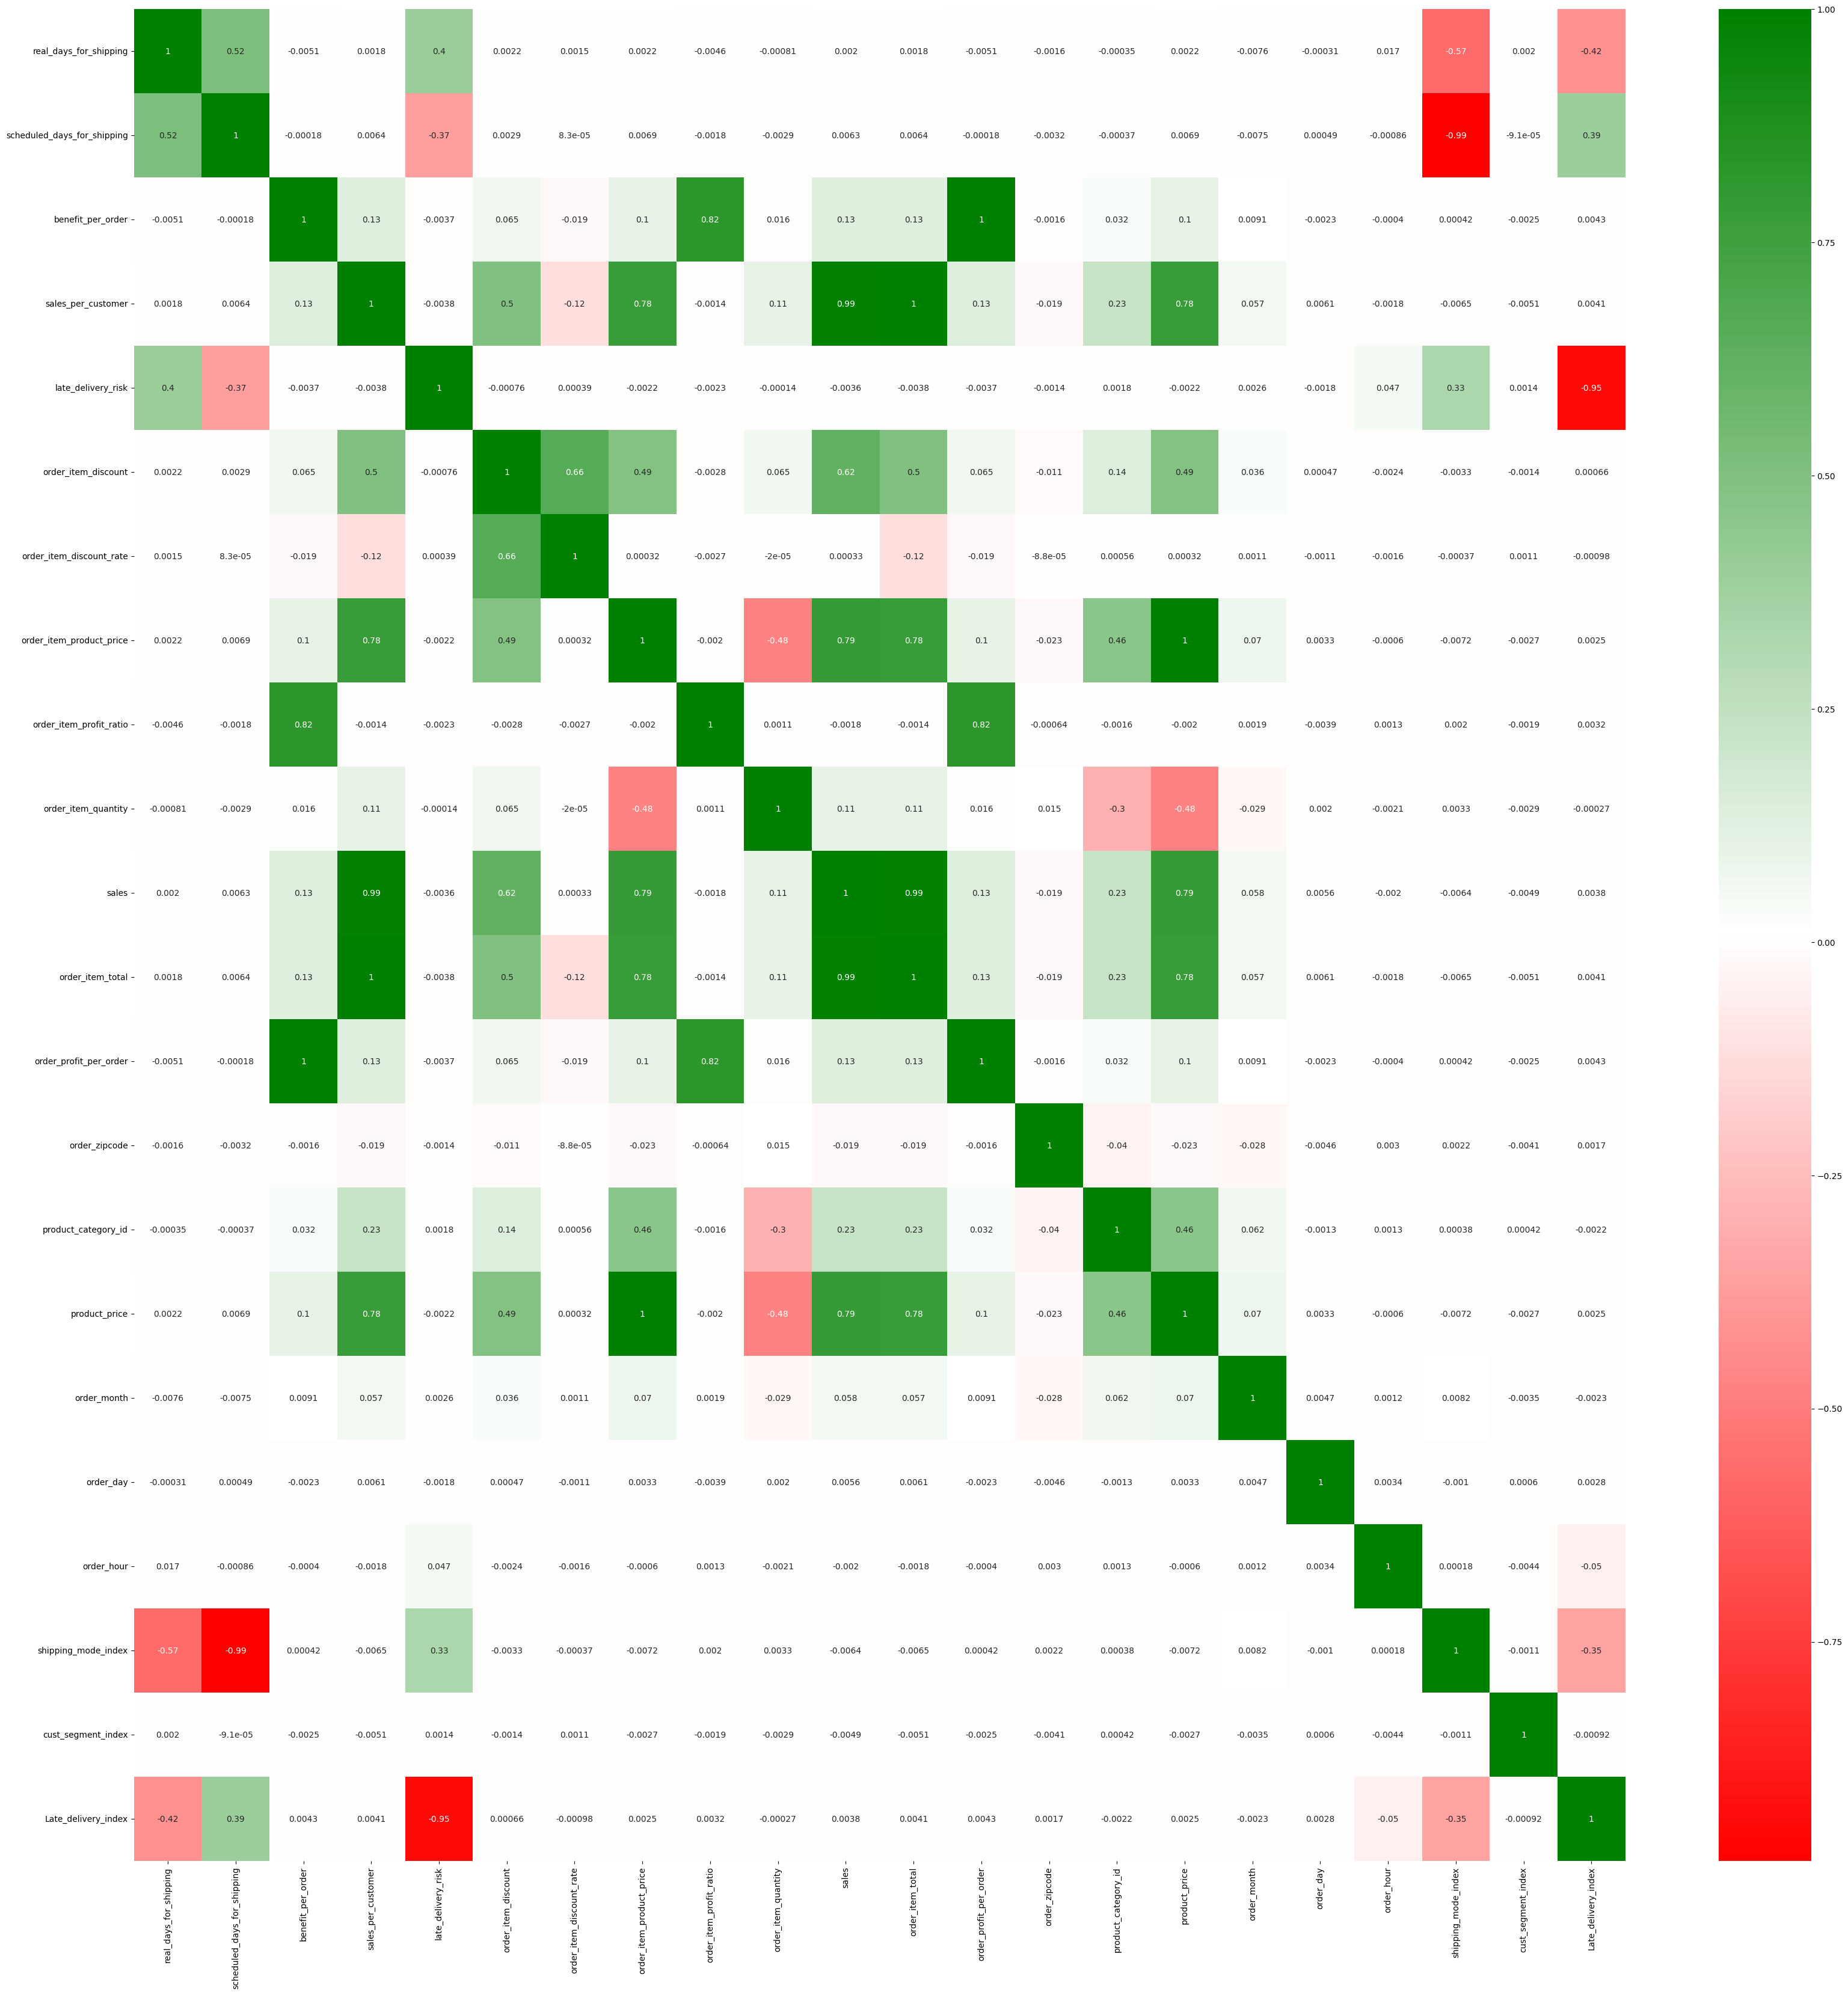

In [42]:
# bringing to pandas to visualize

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Correlation matrix
corr_matrix = matrix.collect()[0][0].toArray().tolist()
corr_matrix_df = pd.DataFrame(data=corr_matrix, columns = assembler_inputs, index=assembler_inputs)

# Define custom colormap
colors = [(0, 'red'), (0.5, 'white'), (1, 'green')]
cmap = LinearSegmentedColormap.from_list('Custom', colors)

plt.figure(figsize=(40,40))
sns.heatmap(corr_matrix_df,
            xticklabels=corr_matrix_df.columns.values,
            yticklabels=corr_matrix_df.columns.values,  cmap=cmap, annot=True)

In [43]:
# Final Data

# Removing some columns
remove_col_l = ['real_days_for_shipping'
                #, 'scheduled_days_for_shipping'
                , 'late_delivery_risk']

final_data_sdf = data_3_sdf.drop(*remove_col_l)

# Define the split ratios for training and testing data
train_ratio = 0.8  # 80% of data for training, 20% for testing
test_ratio = 1 - train_ratio

# Split the data into training and testing sets
train_sdf, test_sdf = final_data_sdf.randomSplit([train_ratio, test_ratio], seed=98)

In [44]:
train_sdf.printSchema()

root
 |-- type: string (nullable = true)
 |-- scheduled_days_for_shipping: integer (nullable = true)
 |-- benefit_per_order: double (nullable = true)
 |-- sales_per_customer: double (nullable = true)
 |-- prod_cat_name: string (nullable = true)
 |-- cust_city: string (nullable = true)
 |-- cust_country: string (nullable = true)
 |-- cust_segment: string (nullable = true)
 |-- cust_state: string (nullable = true)
 |-- cust_street: string (nullable = true)
 |-- cust_zipcode: integer (nullable = true)
 |-- department_name: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- market: string (nullable = true)
 |-- order_city: string (nullable = true)
 |-- order_country: string (nullable = true)
 |-- order_date: timestamp (nullable = true)
 |-- order_item_discount: double (nullable = true)
 |-- order_item_discount_rate: double (nullable = true)
 |-- order_item_product_price: double (nullable = true)
 |-- order_item_profit_ratio: doubl

In [45]:
# dim_l = ['cust_state', 'Late_delivery']
col_s = 'cust_segment'

# Calculate total count for each customer state
total_counts_df = data_3_sdf.groupBy(col_s).count().withColumnRenamed('count', 'total_count')

# Group by count
temp_sdf = data_3_sdf
# Only Late
temp_sdf = temp_sdf.filter(fn.col('Late_delivery')==fn.lit('Late'))
# Group by count
temp_sdf = temp_sdf.groupby(col_s).agg(fn.count('*').alias('count'), fn.avg('late_days').alias('avg_late_days'))


# Join total counts with the original data
temp_sdf = total_counts_df.join(temp_sdf, on=col_s, how = 'left').fillna(0)

# Calculate percentage of late delivery
temp_sdf = temp_sdf.withColumn('late_delivery_percentage', fn.col('count') / fn.col('total_count') * 100)

data_df = temp_sdf.select(col_s, 'count', 'total_count', 'avg_late_days', 'late_delivery_percentage').toPandas()
data_df = data_df.sort_values(by = 'late_delivery_percentage').reset_index(drop = True)
data_df.head(50)

,cust_segment,count,total_count,avg_late_days,late_delivery_percentage
0,Corporate,31291,54788,1.621808,57.112871
1,Consumer,53572,93502,1.611159,57.295031
2,Home Office,18536,32226,1.624353,57.518774


# Random Forest

In [46]:
# Encode categorical variable

from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StringIndexer, OneHotEncoder, Binarizer
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
# from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
# Encode categorical variable

from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline


col_l = train_sdf.columns

y_col = 'Late_delivery'

columns_to_index = []#['shipping_mode', 'cust_segment']

index_order_dict = {'shipping_mode': ['Same Day', 'First Class', 'Standard Class', 'Second Class']
                    , 'cust_segment': ['Corporate', 'Home Office', 'Consumer']}

columns_to_encode = ['type'
                    # , 'delivery_status'
                    , 'prod_cat_name'
                    , 'cust_city'
                    , 'cust_country'
                    , 'cust_segment'
                    , 'cust_state'
                    , 'cust_street'
                    , 'cust_zipcode'
                    , 'department_name'
                    , 'market'
                    , 'order_city'
                    , 'order_country'
                    , 'order_region'
                    , 'order_state'
                    , 'order_status'
                    , 'order_year'
                    # , 'order_month'
                    # , 'order_day'
                    # , 'order_hour'
                    , 'shipping_mode'
                    ]

remove_col_l = ['order_date', 'shipping_date', 'product_description'
                  , 'longitude', 'latitude', 'late_days'
                  , 'product_status', 'delivery_status'
                  ]

remove_col_l = remove_col_l + [y_col]

columns_to_index = [col for col in columns_to_index if (col not in remove_col_l and col in col_l)]
columns_to_encode = [col for col in columns_to_encode if (col not in (remove_col_l + columns_to_index) and col in col_l)]

# Create a list of stages for the Pipeline
stages = []

# Iterate over each categorical column
for col in (columns_to_index + columns_to_encode):
  if col in remove_col_l:
    break
  else:
    # StringIndexer to convert categorical values to indices
    # if col in index_order_dict.keys():
    #   indexer = StringIndexer(inputCol=col, outputCol=f"{col}_index")
    # else:
    indexer = StringIndexer(inputCol=col, outputCol=f"{col}_index")
    stages += [indexer]
    if col in columns_to_encode:
      encoder = OneHotEncoder(inputCol=f"{col}_index", outputCol=f"{col}_encode", dropLast=False)
      stages += [encoder]


# Assemble all encoded features into a single vector
assembler_inputs = [col for col in col_l if col not in (columns_to_index + columns_to_encode + remove_col_l)]\
                    + [f"{col}_index" for col in columns_to_index] \
                    + [f"{col}_encode" for col in columns_to_encode]

vector_col = "features"
assembler = VectorAssembler(inputCols=assembler_inputs, outputCol=vector_col)
stages.append(assembler)

# Label col
# StringIndexer
indexer = StringIndexer(inputCol=y_col, outputCol='label')
stages.append(indexer)
# # Binarize label
# ohe = OneHotEncoder(inputCol=f"{y_col}_index", outputCol='label')
# stages.append(ohe)


# Random Forest
rf = RandomForestClassifier(featuresCol = "features", labelCol = 'label')
stages.append(rf)

# Create the Pipeline
rf_pipeline = Pipeline(stages=stages)


In [48]:
# Training the Random Forest Model

# Fit the Pipeline to the DataFrame
rf_model = rf_pipeline.fit(train_sdf)

In [49]:
# Prediction
predictions = rf_model.transform(train_sdf)

# Columns to keep
col_l = ['features', 'label', 'rawPrediction', 'probability', 'prediction']

# Prediction
predictions = predictions.select(*col_l)

# Display
predictions.show(15)

+--------------------+-----+--------------------+--------------------+----------+
|            features|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|(13910,[1,2,3,4,5...|  0.0|[13.0811649097232...|[0.65405824548616...|       0.0|
|(13910,[1,2,3,4,5...|  1.0|[13.0254223933348...|[0.65127111966674...|       0.0|
|(13910,[1,2,3,4,5...|  0.0|[13.0811649097232...|[0.65405824548616...|       0.0|
|(13910,[1,2,3,4,5...|  0.0|[13.0811649097232...|[0.65405824548616...|       0.0|
|(13910,[1,2,3,4,5...|  0.0|[12.8358459326657...|[0.64179229663328...|       0.0|
|(13910,[1,2,3,4,5...|  1.0|[13.0254223933348...|[0.65127111966674...|       0.0|
|(13910,[1,2,3,4,5...|  0.0|[13.0811649097232...|[0.65405824548616...|       0.0|
|(13910,[1,2,3,4,5...|  1.0|[12.7801034162773...|[0.63900517081386...|       0.0|
|(13910,[1,2,3,4,5...|  0.0|[12.7244235437589...|[0.63622117718794...|       0.0|
|(13910,[1,2,3,4

In [50]:
from pyspark.mllib.evaluation import BinaryClassificationMetrics, MulticlassMetrics

# Make prediction
predictionAndTarget = predictions.select("label", "prediction")

# Create both evaluators
metrics_binary = BinaryClassificationMetrics(predictionAndTarget.rdd.map(tuple))
metrics_multi = MulticlassMetrics(predictionAndTarget.rdd.map(tuple))

# Calculate Evaluation Metric
accuracy = metrics_multi.accuracy
auc = metrics_binary.areaUnderROC

print(f'Accuracy: {accuracy:.4f} [{accuracy:.2%}]')
print(f'AUC: {auc:.4f} [{auc:.2%}]')

/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Accuracy: 0.5749 [57.49%]
AUC: 0.7328 [73.28%]


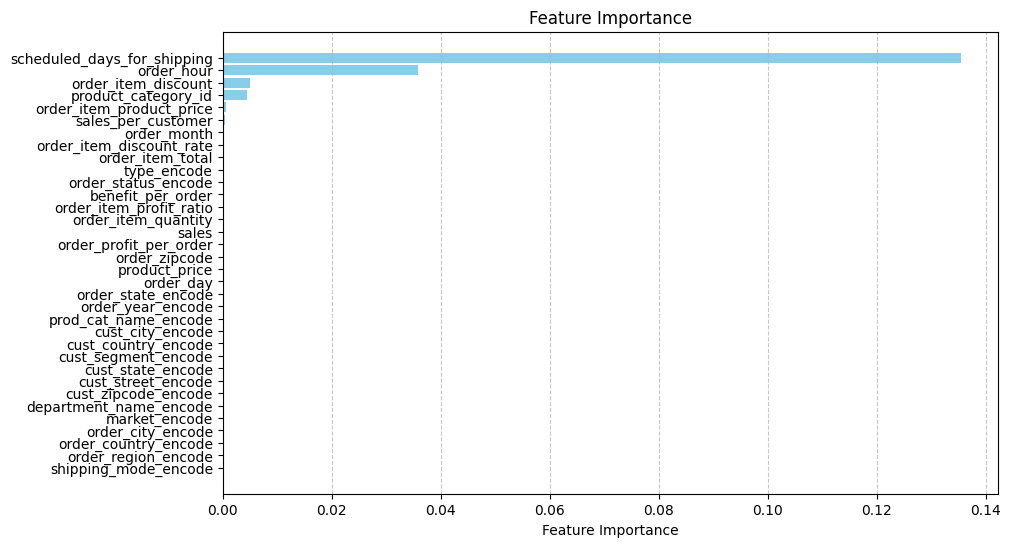

,COL,FI
14,order_state_encode,0.000000
15,order_day,0.000000
16,product_price,0.000000
17,order_zipcode,0.000000
18,order_profit_per_order,0.000000
19,sales,0.000000
20,order_item_quantity,0.000000
21,order_item_profit_ratio,0.000000
22,benefit_per_order,0.000000
23,order_status_encode,0.000000


In [51]:
# FEATURE IMPORTANCE
import pandas as pd
import matplotlib.pyplot as plt

va = rf_model.stages[-3]
rf = rf_model.stages[-1]

# display(rf) #visualize the decision tree model
# print(rf.toDebugString) #print the nodes of the decision tree model

data_l = list(zip(va.getInputCols(), rf.featureImportances))
fi_df = pd.DataFrame(data_l, columns=['COL', 'FI'])

fi_df = fi_df.sort_values(by='FI', ascending=True).reset_index(drop = True)


# Plotting
plt.figure(figsize=(10, 6))
plt.barh(fi_df['COL'], fi_df['FI'], color='skyblue')
plt.xlabel('Feature Importance')
plt.title('Feature Importance')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

display(fi_df.tail(20))

---


## Logistic Regression Model

In [52]:
# Encode categorical variable

from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StringIndexer, OneHotEncoder, Binarizer
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import LogisticRegression
# from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
# Encode categorical variable

from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline


col_l = train_sdf.columns

y_col = 'Late_delivery'

columns_to_index = []#['shipping_mode', 'cust_segment']

index_order_dict = {'shipping_mode': ['Same Day', 'First Class', 'Standard Class', 'Second Class']
                    , 'cust_segment': ['Corporate', 'Home Office', 'Consumer']}

columns_to_encode = ['type'
                    # , 'delivery_status'
                    , 'prod_cat_name'
                    , 'cust_city'
                    , 'cust_country'
                    , 'cust_segment'
                    , 'cust_state'
                    , 'cust_street'
                    , 'cust_zipcode'
                    , 'department_name'
                    , 'market'
                    , 'order_city'
                    , 'order_country'
                    , 'order_region'
                    , 'order_state'
                    , 'order_status'
                    , 'order_year'
                    # , 'order_month'
                    # , 'order_day'
                    # , 'order_hour'
                    , 'shipping_mode'
                    ]

remove_col_l = ['order_date', 'shipping_date', 'product_description'
                  , 'longitude', 'latitude', 'late_days'
                  , 'product_status', 'delivery_status'
                  ]

remove_col_l = remove_col_l + [y_col]

columns_to_index = [col for col in columns_to_index if (col not in remove_col_l and col in col_l)]
columns_to_encode = [col for col in columns_to_encode if (col not in (remove_col_l + columns_to_index) and col in col_l)]

# Create a list of stages for the Pipeline
stages = []

# Iterate over each categorical column
for col in (columns_to_index + columns_to_encode):
  if col in remove_col_l:
    break
  else:
    # StringIndexer to convert categorical values to indices
    # if col in index_order_dict.keys():
    #   indexer = StringIndexer(inputCol=col, outputCol=f"{col}_index")
    # else:
    indexer = StringIndexer(inputCol=col, outputCol=f"{col}_index")
    stages += [indexer]
    if col in columns_to_encode:
      encoder = OneHotEncoder(inputCol=f"{col}_index", outputCol=f"{col}_encode", dropLast=False)
      stages += [encoder]


# Assemble all encoded features into a single vector
assembler_inputs = [col for col in col_l if col not in (columns_to_index + columns_to_encode + remove_col_l)]\
                    + [f"{col}_index" for col in columns_to_index] \
                    + [f"{col}_encode" for col in columns_to_encode]

vector_col = "features"
assembler = VectorAssembler(inputCols=assembler_inputs, outputCol=vector_col)
stages.append(assembler)

# Label col
# StringIndexer
indexer = StringIndexer(inputCol=y_col, outputCol='label')
stages.append(indexer)


# initialize the logistic regression model
log_reg = LogisticRegression(featuresCol = "features", labelCol = 'label')
stages.append(log_reg)

# Create the Pipeline
lr_pipeline = Pipeline(stages=stages)


In [53]:
# Training the Logistic Regresssion Model

# Fit the Pipeline to the DataFrame
lr_model = lr_pipeline.fit(train_sdf)

In [54]:
# Prediction
predictions = lr_model.transform(train_sdf)

# Columns to keep
col_l = ['features', 'label', 'rawPrediction', 'probability', 'prediction']

# Prediction
predictions = predictions.select(*col_l)

# Display
predictions.show(15)

+--------------------+-----+--------------------+--------------------+----------+
|            features|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|(13910,[1,2,3,4,5...|  0.0|[10.3950016836478...|[0.99996941596044...|       0.0|
|(13910,[1,2,3,4,5...|  1.0|[-1.9755892618805...|[0.12178981100794...|       1.0|
|(13910,[1,2,3,4,5...|  0.0|[-0.0832563278576...|[0.47919793264311...|       1.0|
|(13910,[1,2,3,4,5...|  0.0|[1.81991198982972...|[0.86055556618088...|       0.0|
|(13910,[1,2,3,4,5...|  0.0|[1.73437237339839...|[0.84997084071256...|       0.0|
|(13910,[1,2,3,4,5...|  1.0|[1.57874355332520...|[0.82902650088016...|       0.0|
|(13910,[1,2,3,4,5...|  0.0|[-0.0491099686639...|[0.48772497479909...|       1.0|
|(13910,[1,2,3,4,5...|  1.0|[-2.8055127977922...|[0.05702700067292...|       1.0|
|(13910,[1,2,3,4,5...|  0.0|[2.60074792577548...|[0.93090969937853...|       0.0|
|(13910,[1,2,3,4

In [55]:
from pyspark.mllib.evaluation import BinaryClassificationMetrics, MulticlassMetrics

# Make prediction
predictionAndTarget = predictions.select("label", "prediction")

# Create both evaluators
metrics_binary = BinaryClassificationMetrics(predictionAndTarget.rdd.map(tuple))
metrics_multi = MulticlassMetrics(predictionAndTarget.rdd.map(tuple))

# Calculate Evaluation Metric
accuracy = metrics_multi.accuracy
precision = metrics_multi.precision(1.0)
recall = metrics_multi.recall(1.0)
f1_score = metrics_multi.fMeasure(1.0)
auc = metrics_binary.areaUnderROC

print(f'Accuracy: {accuracy:.4f} [{accuracy:.2%}]')
print(f'Precision: {precision:.4f} [{precision:.2%}]')
print(f'Recall: {recall:.4f} [{recall:.2%}]')
print(f'F1 Score: {f1_score:.4f} [{f1_score:.2%}]')
print(f'AUC: {auc:.4f} [{auc:.2%}]')

/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Accuracy: 0.8101 [81.01%]
Precision: 0.7995 [79.95%]
Recall: 0.7665 [76.65%]
F1 Score: 0.7826 [78.26%]
AUC: 0.8059 [80.59%]


In [56]:
cf_matrix = metrics_multi.confusionMatrix().toArray()

Text(50.722222222222214, 0.5, 'Real Label')

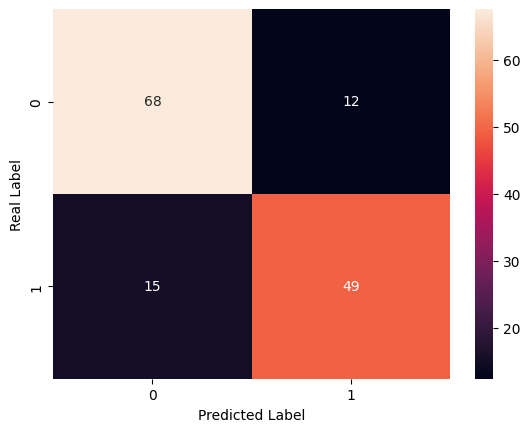

In [57]:
sns.heatmap(cf_matrix/1000, annot=True)
# Set labels
plt.xlabel('Predicted Label')
plt.ylabel('Real Label')

In [58]:
y_true = predictions.select(['label']).collect()
y_pred = predictions.select(['prediction']).collect()

from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

         0.0       0.85      0.82      0.83     82549
         1.0       0.77      0.80      0.78     61636

    accuracy                           0.81    144185
   macro avg       0.81      0.81      0.81    144185
weighted avg       0.81      0.81      0.81    144185



In [59]:
# Prediction
test_predictions = lr_model.transform(test_sdf)

# Columns to keep
col_l = ['features', 'label', 'rawPrediction', 'probability', 'prediction']

# Prediction
test_predictions = test_predictions.select(*col_l)

# Display
test_predictions.show(15)

+--------------------+-----+--------------------+--------------------+----------+
|            features|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|(13910,[1,2,3,4,5...|  1.0|[-0.5191574682895...|[0.37304926687535...|       1.0|
|(13910,[1,2,5,6,7...|  0.0|[10.6497450618734...|[0.99997629367738...|       0.0|
|(13910,[1,2,3,4,5...|  1.0|[-0.6042632168463...|[0.35336894370756...|       1.0|
|(13910,[1,2,3,4,5...|  0.0|[0.24417865270400...|[0.56074315415529...|       0.0|
|(13910,[1,2,3,4,5...|  0.0|[-0.1052097290000...|[0.47372180291695...|       1.0|
|(13910,[1,2,3,4,5...|  0.0|[0.43722129226809...|[0.60759672150759...|       0.0|
|(13910,[1,2,3,4,5...|  1.0|[0.52059030086735...|[0.62728578803561...|       0.0|
|(13910,[1,2,3,4,5...|  0.0|[0.44311772224143...|[0.60900167028847...|       0.0|
|(13910,[1,2,3,4,5...|  1.0|[-0.9044664890728...|[0.28813349802239...|       1.0|
|(13910,[1,2,3,4

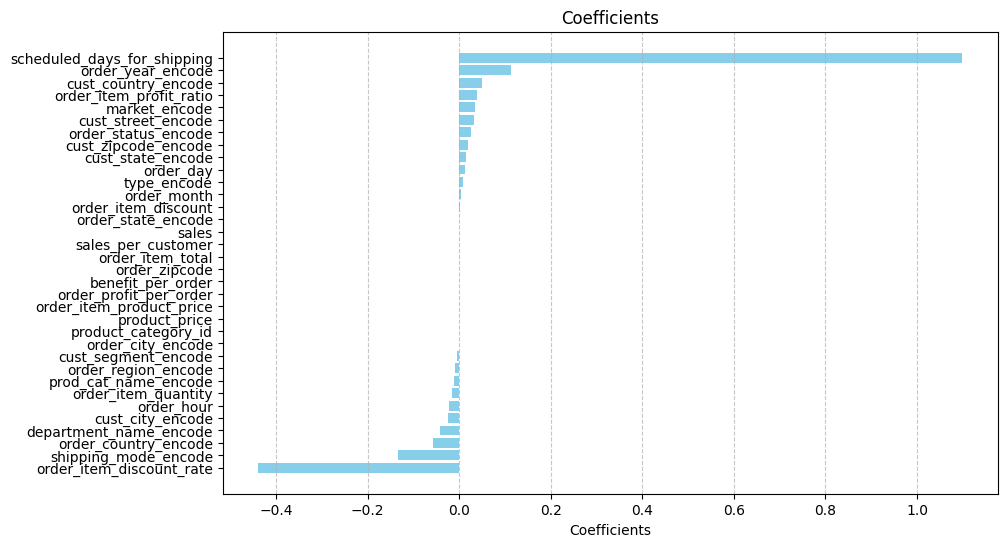

,COL,Coef
0,order_item_discount_rate,-0.439589
1,shipping_mode_encode,-0.134228
2,order_country_encode,-0.057889
3,department_name_encode,-0.040840
4,cust_city_encode,-0.025360
5,order_hour,-0.022322
6,order_item_quantity,-0.014685
7,prod_cat_name_encode,-0.011862
8,order_region_encode,-0.009383
9,cust_segment_encode,-0.005417


,COL,Coef
24,order_day,0.013630
25,cust_state_encode,0.015565
26,cust_zipcode_encode,0.019063
27,order_status_encode,0.025207
28,cust_street_encode,0.031352
29,market_encode,0.033838
30,order_item_profit_ratio,0.039595
31,cust_country_encode,0.049988
32,order_year_encode,0.113174
33,scheduled_days_for_shipping,1.099427


In [60]:
#
import pandas as pd
import matplotlib.pyplot as plt

va = lr_model.stages[-3]
lr = lr_model.stages[-1]

data_l = list(zip(va.getInputCols(), lr.coefficients))
fi_df = pd.DataFrame(data_l, columns=['COL', 'Coef'])

fi_df = fi_df.sort_values(by='Coef', ascending=True).reset_index(drop = True)


# Plotting
plt.figure(figsize=(10, 6))
plt.barh(fi_df['COL'], fi_df['Coef'], color='skyblue')
plt.xlabel('Coefficients')
plt.title('Coefficients')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

display(fi_df.head(10))
display(fi_df.tail(10))

In [61]:
fi_df['abs_coef'] = abs(fi_df['Coef'])
fi_df = fi_df.sort_values(by = 'abs_coef', ascending = False)
fi_df.head(10)['COL']

33    scheduled_days_for_shipping
0        order_item_discount_rate
1            shipping_mode_encode
32              order_year_encode
2            order_country_encode
31            cust_country_encode
3          department_name_encode
30        order_item_profit_ratio
29                  market_encode
28             cust_street_encode
Name: COL, dtype: object

In [62]:
data_3_sdf.printSchema()

root
 |-- type: string (nullable = true)
 |-- real_days_for_shipping: integer (nullable = true)
 |-- scheduled_days_for_shipping: integer (nullable = true)
 |-- benefit_per_order: double (nullable = true)
 |-- sales_per_customer: double (nullable = true)
 |-- late_delivery_risk: integer (nullable = true)
 |-- prod_cat_name: string (nullable = true)
 |-- cust_city: string (nullable = true)
 |-- cust_country: string (nullable = true)
 |-- cust_segment: string (nullable = true)
 |-- cust_state: string (nullable = true)
 |-- cust_street: string (nullable = true)
 |-- cust_zipcode: integer (nullable = true)
 |-- department_name: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- market: string (nullable = true)
 |-- order_city: string (nullable = true)
 |-- order_country: string (nullable = true)
 |-- order_date: timestamp (nullable = true)
 |-- order_item_discount: double (nullable = true)
 |-- order_item_discount_rate: double (nu

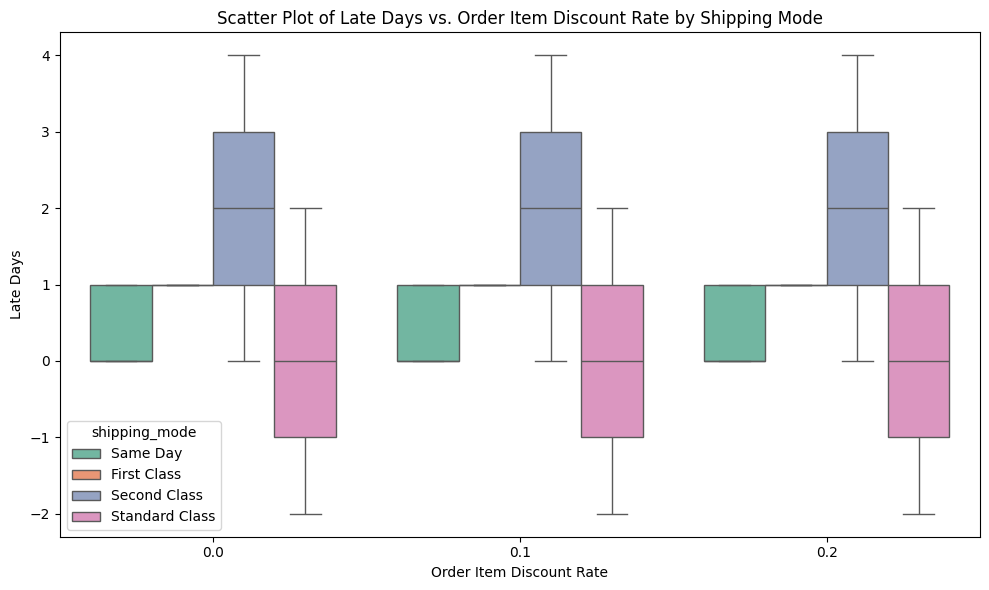

In [63]:
temp_sdf = data_3_sdf

temp_df = temp_sdf.select('order_item_discount_rate', 'shipping_mode', 'late_days')

# Define the bin size
bin_size = 0.1

# Calculate the bin for 'order_item_discount_rate'
temp_sdf = temp_sdf.withColumn('order_item_discount_rate_bins', (fn.floor(fn.col('order_item_discount_rate') / fn.lit(bin_size)) * fn.lit(bin_size)))

temp_df = temp_sdf.select('order_item_discount_rate_bins', 'shipping_mode', 'late_days').sample(False, .3).toPandas()


# Order
shipping_mode_order = ['Same Day', 'First Class', 'Second Class', 'Standard Class']


# Plotting with Seaborn
plt.figure(figsize=(10, 6))
sns.boxplot(data=temp_df, x='order_item_discount_rate_bins', y='late_days', hue='shipping_mode', hue_order=shipping_mode_order, palette='Set2')
plt.xlabel('Order Item Discount Rate')
plt.ylabel('Late Days')
plt.title('Scatter Plot of Late Days vs. Order Item Discount Rate by Shipping Mode')
plt.tight_layout()
plt.show()

In [64]:
# dim_l = ['cust_state', 'Late_delivery']
col_s = 'cust_country'

# Calculate total count for each customer state
total_counts_df = data_3_sdf.groupBy(col_s).count().withColumnRenamed('count', 'total_count')

# Group by count
temp_sdf = data_3_sdf
# Only Late
temp_sdf = temp_sdf.filter(fn.col('Late_delivery')==fn.lit('Late'))
# Group by count
temp_sdf = temp_sdf.groupby(col_s).agg(fn.count('*').alias('count'), fn.avg('late_days').alias('avg_late_days'))


# Join total counts with the original data
temp_sdf = total_counts_df.join(temp_sdf, on=col_s, how = 'left').fillna(0)

# Calculate percentage of late delivery
temp_sdf = temp_sdf.withColumn('late_delivery_percentage', fn.col('count') / fn.col('total_count') * 100)

data_df = temp_sdf.select(col_s, 'count', 'total_count', 'avg_late_days', 'late_delivery_percentage').toPandas()

data_df.head(50)

,cust_country,count,total_count,avg_late_days,late_delivery_percentage
0,Puerto Rico,39704,69373,1.615631,57.232641
1,EE. UU.,63695,111143,1.617442,57.309052


In [65]:
data_3_sdf.select('cust_segment').distinct().show()

+------------+
|cust_segment|
+------------+
|    Consumer|
| Home Office|
|   Corporate|
+------------+



In [66]:
data_3_sdf.printSchema()

root
 |-- type: string (nullable = true)
 |-- real_days_for_shipping: integer (nullable = true)
 |-- scheduled_days_for_shipping: integer (nullable = true)
 |-- benefit_per_order: double (nullable = true)
 |-- sales_per_customer: double (nullable = true)
 |-- late_delivery_risk: integer (nullable = true)
 |-- prod_cat_name: string (nullable = true)
 |-- cust_city: string (nullable = true)
 |-- cust_country: string (nullable = true)
 |-- cust_segment: string (nullable = true)
 |-- cust_state: string (nullable = true)
 |-- cust_street: string (nullable = true)
 |-- cust_zipcode: integer (nullable = true)
 |-- department_name: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- market: string (nullable = true)
 |-- order_city: string (nullable = true)
 |-- order_country: string (nullable = true)
 |-- order_date: timestamp (nullable = true)
 |-- order_item_discount: double (nullable = true)
 |-- order_item_discount_rate: double (nu

In [67]:
data_3_sdf.select('Late_delivery').distinct().show()

+-------------+
|Late_delivery|
+-------------+
|         Late|
|     Not Late|
+-------------+



In [68]:
# dim_l = ['cust_state', 'Late_delivery']
col_s = 'cust_state'

# Calculate total count for each customer state
total_counts_df = data_3_sdf.groupBy(col_s).count().withColumnRenamed('count', 'total_count')

# Group by count
temp_sdf = data_3_sdf
# Only Late
temp_sdf = temp_sdf.filter(fn.col('Late_delivery')==fn.lit('Late'))
# Group by count
temp_sdf = temp_sdf.groupby(col_s).agg(fn.count('*').alias('count'), fn.avg('late_days').alias('avg_late_days'))


# Join total counts with the original data
temp_sdf = total_counts_df.join(temp_sdf, on=col_s, how = 'left').fillna(0)

# Calculate percentage of late delivery
temp_sdf = temp_sdf.withColumn('late_delivery_percentage', fn.col('count') / fn.col('total_count') * 100)

data_df = temp_sdf.select(col_s, 'count', 'total_count', 'avg_late_days', 'late_delivery_percentage').toPandas()

data_df.head(50)

,cust_state,count,total_count,avg_late_days,late_delivery_percentage
0,AZ,1626,3026,1.602706,53.734303
1,SC,391,665,1.386189,58.796992
2,LA,529,948,1.661626,55.801688
3,MN,403,672,1.615385,59.970238
4,NJ,1768,3191,1.658937,55.405829
5,DC,359,579,1.738162,62.003454
6,OR,945,1668,1.593651,56.654676
7,VA,1047,1849,1.622732,56.625203
8,RI,133,243,1.593985,54.732510
9,KY,278,487,1.712230,57.084189


<Figure size 2000x1000 with 0 Axes>

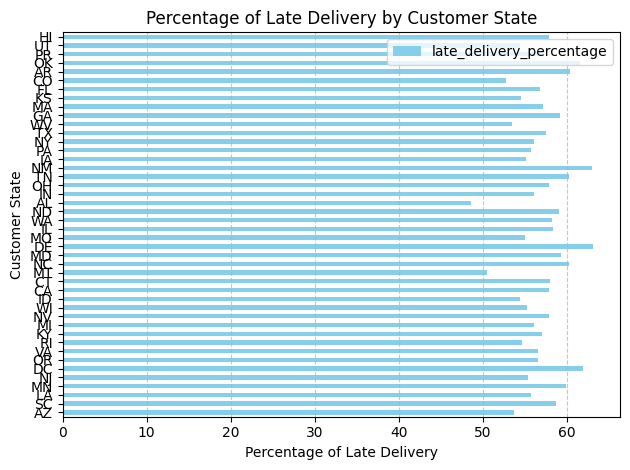

In [69]:

# Plotting
plt.figure(figsize=(20, 10))
data_df.plot(kind='barh', x='cust_state', y='late_delivery_percentage', color='skyblue')
plt.xlabel('Percentage of Late Delivery')
plt.ylabel('Customer State')
plt.title('Percentage of Late Delivery by Customer State')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

---

# Data Exploration

In [70]:
# dim_l = ['cust_state', 'Late_delivery']
col_s = 'cust_country'

# Calculate total count for each customer state
total_counts_df = data_3_sdf.groupBy(col_s).count().withColumnRenamed('count', 'total_count')

# Group by count
temp_sdf = data_3_sdf
# Only Late
temp_sdf = temp_sdf.filter(fn.col('Late_delivery')==fn.lit('Late'))
# Group by count
temp_sdf = temp_sdf.groupby(col_s).agg(fn.count('*').alias('count'), fn.avg('late_days').alias('avg_late_days'))


# Join total counts with the original data
temp_sdf = total_counts_df.join(temp_sdf, on=col_s, how = 'left').fillna(0)

# Calculate percentage of late delivery
temp_sdf = temp_sdf.withColumn('late_delivery_percentage', fn.col('count') / fn.col('total_count') * 100)

data_df = temp_sdf.select(col_s, 'count', 'total_count', 'avg_late_days', 'late_delivery_percentage').toPandas()

data_df.head(50)

,cust_country,count,total_count,avg_late_days,late_delivery_percentage
0,Puerto Rico,39704,69373,1.615631,57.232641
1,EE. UU.,63695,111143,1.617442,57.309052


In [71]:
# dim_l = ['cust_state', 'Late_delivery']
col_s = 'order_hour'

# Calculate total count for each customer state
total_counts_df = data_3_sdf.groupBy(col_s).count().withColumnRenamed('count', 'total_count')

# Group by count
temp_sdf = data_3_sdf
# Only Late
temp_sdf = temp_sdf.filter(fn.col('Late_delivery')==fn.lit('Late'))
# Group by count
temp_sdf = temp_sdf.groupby(col_s).agg(fn.count('*').alias('count'), fn.avg('late_days').alias('avg_late_days'))


# Join total counts with the original data
temp_sdf = total_counts_df.join(temp_sdf, on=col_s, how = 'left').fillna(0)

# Calculate percentage of late delivery
temp_sdf = temp_sdf.withColumn('late_delivery_percentage', fn.col('count') / fn.col('total_count') * 100)

data_df = temp_sdf.select(col_s, 'count', 'total_count', 'avg_late_days', 'late_delivery_percentage').toPandas()

data_df.head(50)

,order_hour,count,total_count,avg_late_days,late_delivery_percentage
0,12,4647,7486,1.607919,62.075875
1,22,4543,7418,1.568787,61.242923
2,1,4183,7559,1.626345,55.338008
3,13,4589,7578,1.556766,60.556875
4,6,3808,7270,1.655725,52.379642
5,16,4411,7501,1.600998,58.805493
6,3,4017,7440,1.651481,53.991935
7,20,4625,7481,1.595892,61.823286
8,5,4195,7591,1.641240,55.262811
9,19,4353,7554,1.593614,57.625099


In [72]:
# dim_l = ['cust_state', 'Late_delivery']
col_s = 'cust_segment'

# Calculate total count for each customer state
total_counts_df = data_3_sdf.groupBy(col_s).count().withColumnRenamed('count', 'total_count')

# Group by count
temp_sdf = data_3_sdf
# Only Late
temp_sdf = temp_sdf.filter(fn.col('Late_delivery')==fn.lit('Late'))
# Group by count
temp_sdf = temp_sdf.groupby(col_s).agg(fn.count('*').alias('count'), fn.avg('late_days').alias('avg_late_days'))


# Join total counts with the original data
temp_sdf = total_counts_df.join(temp_sdf, on=col_s, how = 'left').fillna(0)

# Calculate percentage of late delivery
temp_sdf = temp_sdf.withColumn('late_delivery_percentage', fn.col('count') / fn.col('total_count') * 100)

data_df = temp_sdf.select(col_s, 'count', 'total_count', 'avg_late_days', 'late_delivery_percentage').toPandas()

data_df.head(50)

,cust_segment,count,total_count,avg_late_days,late_delivery_percentage
0,Consumer,53572,93502,1.611159,57.295031
1,Home Office,18536,32226,1.624353,57.518774
2,Corporate,31291,54788,1.621808,57.112871


In [73]:
# dim_l = ['cust_state', 'Late_delivery']
col_s = 'product_status'

# Calculate total count for each customer state
total_counts_df = data_3_sdf.groupBy(col_s).count().withColumnRenamed('count', 'total_count')

# Group by count
temp_sdf = data_3_sdf
# Only Late
temp_sdf = temp_sdf.filter(fn.col('Late_delivery')==fn.lit('Late'))
# Group by count
temp_sdf = temp_sdf.groupby(col_s).agg(fn.count('*').alias('count'), fn.avg('late_days').alias('avg_late_days'))


# Join total counts with the original data
temp_sdf = total_counts_df.join(temp_sdf, on=col_s, how = 'left').fillna(0)

# Calculate percentage of late delivery
temp_sdf = temp_sdf.withColumn('late_delivery_percentage', fn.col('count') / fn.col('total_count') * 100)

data_df = temp_sdf.select(col_s, 'count', 'total_count', 'avg_late_days', 'late_delivery_percentage').toPandas()

data_df.head(50)

,product_status,count,total_count,avg_late_days,late_delivery_percentage
0,0,103399,180516,1.616747,57.279687


In [74]:
# dim_l = ['cust_state', 'Late_delivery']
col_s = 'shipping_mode'

# Calculate total count for each customer state
total_counts_df = data_3_sdf.groupBy(col_s).count().withColumnRenamed('count', 'total_count')

# Group by count
temp_sdf = data_3_sdf
# Only Late
temp_sdf = temp_sdf.filter(fn.col('Late_delivery')==fn.lit('Late'))
# Group by count
temp_sdf = temp_sdf.groupby(col_s).agg(fn.count('*').alias('count'), fn.avg('late_days').alias('avg_late_days'))


# Join total counts with the original data
temp_sdf = total_counts_df.join(temp_sdf, on=col_s, how = 'left').fillna(0)

# Calculate percentage of late delivery
temp_sdf = temp_sdf.withColumn('late_delivery_percentage', fn.col('count') / fn.col('total_count') * 100)

data_df = temp_sdf.select(col_s, 'count', 'total_count', 'avg_late_days', 'late_delivery_percentage').toPandas()

data_df.head(50)

,shipping_mode,count,total_count,avg_late_days,late_delivery_percentage
0,First Class,27813,27813,1.000000,100.000000
1,Same Day,4657,9737,1.000000,47.827873
2,Second Class,28078,35216,2.496937,79.730804
3,Standard Class,42851,107750,1.507339,39.768910


In [75]:
# dim_l = ['cust_state', 'Late_delivery']
col_s = 'order_status'

# Calculate total count for each customer state
total_counts_df = data_3_sdf.groupBy(col_s).count().withColumnRenamed('count', 'total_count')

# Group by count
temp_sdf = data_3_sdf
# Only Late
temp_sdf = temp_sdf.filter(fn.col('Late_delivery')==fn.lit('Late'))
# Group by count
temp_sdf = temp_sdf.groupby(col_s).agg(fn.count('*').alias('count'), fn.avg('late_days').alias('avg_late_days'))


# Join total counts with the original data
temp_sdf = total_counts_df.join(temp_sdf, on=col_s, how = 'left').fillna(0)

# Calculate percentage of late delivery
temp_sdf = temp_sdf.withColumn('late_delivery_percentage', fn.col('count') / fn.col('total_count') * 100)

data_df = temp_sdf.select(col_s, 'count', 'total_count', 'avg_late_days', 'late_delivery_percentage').toPandas()

data_df.head(50)

,order_status,count,total_count,avg_late_days,late_delivery_percentage
0,PENDING_PAYMENT,22922,39831,1.650249,57.548141
1,COMPLETE,34198,59489,1.596965,57.486258
2,ON_HOLD,5450,9804,1.603119,55.589555
3,PAYMENT_REVIEW,1082,1893,1.642329,57.157950
4,PROCESSING,12503,21902,1.624010,57.086111
5,CLOSED,11109,19616,1.617517,56.632341
6,SUSPECTED_FRAUD,2316,4062,1.600173,57.016248
7,PENDING,11712,20227,1.616633,57.902803
8,CANCELED,2107,3692,1.567157,57.069339


---

# Additional Plots

In [77]:
# only keeping required columns
t_col_l = ['Type'
        , 'Days for shipping (real)'
        , 'Days for shipment (scheduled)'
        , 'Benefit per order'
        , 'Sales per customer'
        , 'Delivery Status'
        #, 'Late_delivery_risk'
        #, 'Category Id'
        , 'Category Name'
        , 'Customer City'
        #, 'Customer Country'
        # , 'Customer Email'
        # , 'Customer Fname'
        # , 'Customer Id'
        # , 'Customer Lname'
        # , 'Customer Password'
        , 'Customer Segment'
        , 'Customer State'
        #, 'Customer Street'
        , 'Customer Zipcode'
        #, 'Department Id'
        , 'Department Name'
        , 'Latitude'
        , 'Longitude'
        , 'Market'
        , 'Order City'
        , 'Order Country'
        # , 'Order Customer Id'
        , 'order date (DateOrders)'
        # , 'Order Id'
        # , 'Order Item Cardprod Id'
        , 'Order Item Discount'
        , 'Order Item Discount Rate'
        # , 'Order Item Id'
        , 'Order Item Product Price'
        , 'Order Item Profit Ratio'
        , 'Order Item Quantity'
        , 'Sales'
        , 'Order Item Total'
        , 'Order Profit Per Order'
        , 'Order Region'
        , 'Order State'
        #, 'Order Status'
        #, 'Order Zipcode'
        # , 'Product Card Id'
        #, 'Product Category Id'
        #, 'Product Description'
        # , 'Product Image'
         , 'Product Name'
        , 'Product Price'
        #, 'Product Status'
        , 'shipping date (DateOrders)'
        , 'Shipping Mode'
        , 'delayed_shipment_days'
        , 'shipment_delayed'
        , 'profitable'
         #, 'high_margin'
        ]

t_rename_dict={
    'Type': 'Transaction Type'
        , 'Days for shipping (real)': 'processing_time_actual'
        , 'Days for shipment (scheduled)': 'processing_time_estimated'
        , 'Benefit per order': 'earnings_per_order'
        , 'Sales per customer': 'sales_per_customer'
        , 'Delivery Status': 'delivery_status'
        #, 'Late_delivery_risk': 'late_delivery_risk'
        #, 'Category Id': 'prod_cat_id'
        , 'Category Name': 'prod_cat_name'
        , 'Customer City': 'cust_city'
        #, 'Customer Country': 'cust_country'
        #, 'Customer Email': 'cust_email'
        #, 'Customer Fname': 'cust_first_name'
        #, 'Customer Id': 'cust_id'
        #, 'Customer Lname': 'cust_last_name'
        #, 'Customer Password': 'cust_password'
        #, 'Customer Segment': 'cust_segment'
        , 'Customer State': 'cust_state'
        #, 'Customer Street': 'cust_street'
        #, 'Customer Zipcode': 'cust_zipcode'
        #, 'Department Id': 'department_id'
        , 'Department Name': 'department_name'
        #, 'Latitude': 'latitude'
        #, 'Longitude': 'longitude'
        , 'Market': 'market'
        , 'Order City': 'order_city'
        , 'Order Country': 'order_country'
        #, 'Order Customer Id': 'order_cust_id'
        , 'order date (DateOrders)': 'order_date'
        # 'Order Id': 'order_id'
        , 'Order Item Cardprod Id': 'order_item_cardprod_id'
        , 'Order Item Discount': 'order_item_discount'
        , 'Order Item Discount Rate': 'order_item_discount_rate'
        #, 'Order Item Id': 'order_item_id'
        , 'Order Item Product Price': 'order_item_product_price'
        , 'Order Item Profit Ratio': 'order_item_profit_ratio'
        , 'Order Item Quantity': 'order_item_quantity'
        , 'Sales': 'sales'
        , 'Order Item Total': 'order_item_total'
        , 'Order Profit Per Order': 'order_profit_per_order'
        , 'Order Region': 'order_region'
        , 'Order State': 'order_state'
        #, 'Order Status': 'order_status'
        #, 'Order Zipcode': 'order_zipcode'
        #, 'Product Card Id': 'product_card_id'
        #, 'Product Category Id': 'product_category_id'
        #, 'Product Description': 'product_description'
        #, 'Product Image': 'product_image'
        , 'Product Name': 'product_name'
        , 'Product Price': 'product_price'
        #, 'Product Status': 'product_status'
        , 'shipping date (DateOrders)': 'shipping_date'
        , 'Shipping Mode': 'shipping_mode'
}

t_rename_col_l = [t_rename_dict.get(col, col) for col in t_col_l]





#Additional columns

t_data_2_sdf = dataco_sdf

#profit
t_data_2_sdf = t_data_2_sdf.withColumn('profitable', fn.when(fn.col('Order Profit Per Order')<= fn.lit(0), fn.lit(0)).otherwise(fn.lit(1)))


# late days = delayed_shipment_days
t_data_2_sdf = t_data_2_sdf.withColumn('delayed_shipment_days', fn.col('Days for shipping (real)')-fn.col('Days for shipment (scheduled)')) # Created class imbalance # more than 1 day then late

#Formerly Late_delivery = shipment_delayed. Late = Delayte, Not Late = Not Delayed
t_data_2_sdf = t_data_2_sdf.withColumn('shipment_delayed', fn.when(fn.col('delayed_shipment_days')>= fn.lit(1), fn.lit('Delayed')).otherwise(fn.lit('Not Delayed')))

#Margins - more than 20% is good
#data_2_sdf = data_2_sdf.withColumn('high_margin', fn.when(fn.col('order_item_profit_ratio')<= fn.lit(.20), fn.lit(0)).otherwise(fn.lit(1)))


# only keeping required columns
t_data_2_sdf = t_data_2_sdf.select(*[x for x in t_col_l]).toDF(*[x for x in t_rename_col_l])
t_data_2_sdf.show(10)

t_data_3_sdf = t_data_2_sdf

# order date
t_data_3_sdf = t_data_3_sdf.withColumn('order_year', fn.year('order_date'))
t_data_3_sdf = t_data_3_sdf.withColumn('order_month', fn.month('order_date'))
t_data_3_sdf = t_data_3_sdf.withColumn('order_day', fn.dayofweek('order_date'))
t_data_3_sdf = t_data_3_sdf.withColumn('order_hour', fn.hour('order_date'))

# # shipping date
# data_3_sdf = data_3_sdf.withColumn('shipping_year', fn.year('shipping_date'))
# data_3_sdf = data_3_sdf.withColumn('shipping_month', fn.month('shipping_date'))
# data_3_sdf = data_3_sdf.withColumn('shipping_day', fn.dayofweek('shipping_date'))
# data_3_sdf = data_3_sdf.withColumn('shipping_hour', fn.hour('shipping_date'))

t_data_3_sdf.show(5)


+----------------+----------------------+-------------------------+------------------+------------------+-----------------+--------------+-----------+----------------+----------+----------------+---------------+-----------+------------+------------+----------+-------------+-------------------+-------------------+------------------------+------------------------+-----------------------+-------------------+------+----------------+----------------------+--------------+---------------+------------+-------------+-------------------+--------------+---------------------+----------------+----------+
|Transaction Type|processing_time_actual|processing_time_estimated|earnings_per_order|sales_per_customer|  delivery_status| prod_cat_name|  cust_city|Customer Segment|cust_state|Customer Zipcode|department_name|   Latitude|   Longitude|      market|order_city|order_country|         order_date|order_item_discount|order_item_discount_rate|order_item_product_price|order_item_profit_ratio|order_item_qu

+---------+-------------+-----+------------+
|order_day|shipping_mode|count|weekday_name|
+---------+-------------+-----+------------+
|        1|  First Class| 4181|      Sunday|
|        2|  First Class| 3994|      Monday|
|        3|  First Class| 3877|     Tuesday|
|        4|  First Class| 3889|   Wednesday|
|        5|  First Class| 3998|    Thursday|
|        6|  First Class| 3945|      Friday|
|        7|  First Class| 3929|    Saturday|
+---------+-------------+-----+------------+



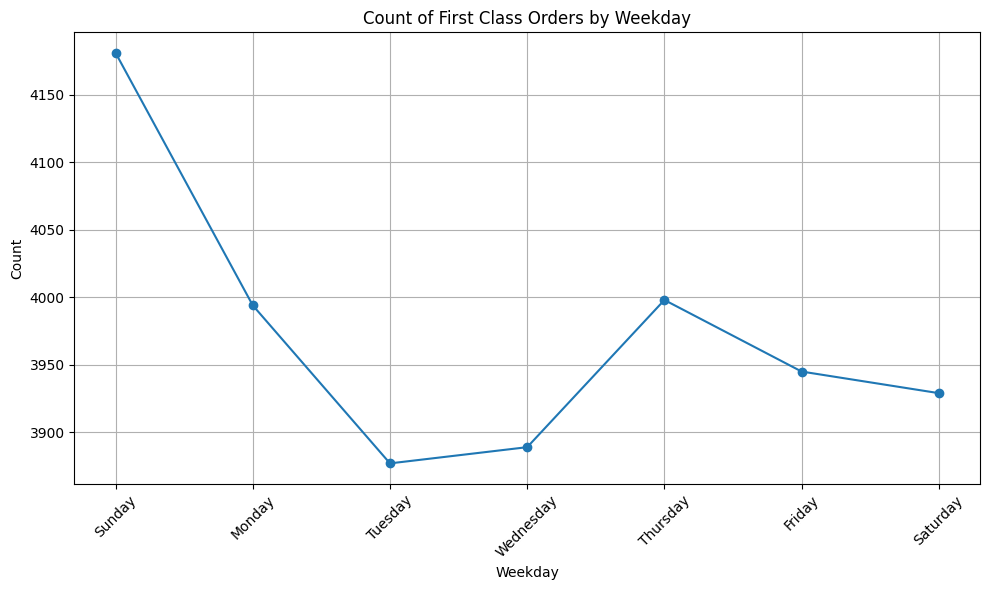

In [78]:
#Import needed modules
from pyspark.sql.functions import desc,when
from pyspark.sql.functions import col
import matplotlib.pyplot as plt

#Groupby shipping mode and order date, then sort the date by the order_date (Sunday = 1, so on and so forth)
order_day_counts = data_3_sdf.groupBy('order_day','shipping_mode').count().orderBy('order_day')


#Create a new column that provides the weekday names instead of just numbers.
order_day_counts = order_day_counts.withColumn('weekday_name',
                                   when(data_3_sdf['order_day'] == 1, 'Sunday')
                                   .when(data_3_sdf['order_day'] == 2, 'Monday')
                                   .when(data_3_sdf['order_day'] == 3, 'Tuesday')
                                   .when(data_3_sdf['order_day'] == 4, 'Wednesday')
                                   .when(data_3_sdf['order_day'] == 5, 'Thursday')
                                   .when(data_3_sdf['order_day'] == 6, 'Friday')
                                   .when(data_3_sdf['order_day'] == 7, 'Saturday')
                                   .otherwise(None))

#Filter out your data to only include First Class Shipping
result_df = order_day_counts.filter(col('shipping_mode') == 'First Class')

# Show the result
result_df.show()

#Convert results toPandas
result_pd = result_df.toPandas()

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(result_pd['weekday_name'], result_pd['count'], marker='o', linestyle='-')
plt.xlabel('Weekday')
plt.ylabel('Count')
plt.title('Count of First Class Orders by Weekday')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

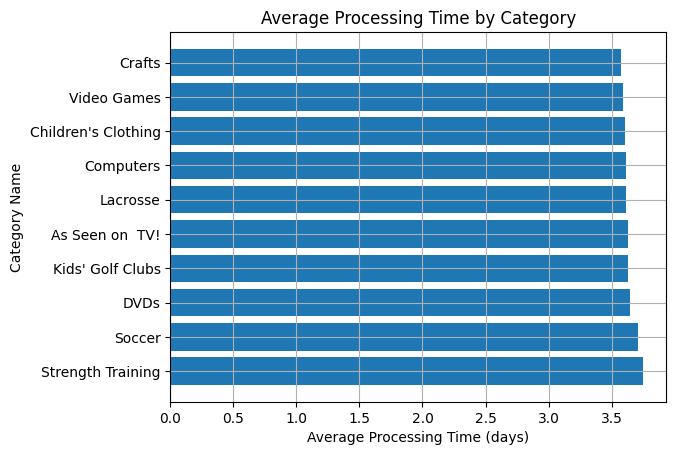

In [79]:
#What products take the longest to process? - Category

import matplotlib.pyplot as plt
from pyspark.sql.functions import avg

# Group by department_name and calculate the average or maximum real_days_for_shipping
department_processing_time = t_data_3_sdf.groupBy('prod_cat_name') \
    .agg(avg('processing_time_actual').alias('avg_processing_time'))

# Sort departments based on processing time
department_processing_time = department_processing_time.orderBy('avg_processing_time', ascending=False)

# Select top 10 departments
department_processing_time = department_processing_time.limit(10)

# Convert to Pandas
department_processing_time_df = department_processing_time.toPandas()


#Plot
plt.barh(department_processing_time_df['prod_cat_name'], department_processing_time_df['avg_processing_time'])
plt.xlabel('Average Processing Time (days)')
plt.ylabel('Category Name')
plt.title('Average Processing Time by Category')
plt.grid(True)
plt.show()

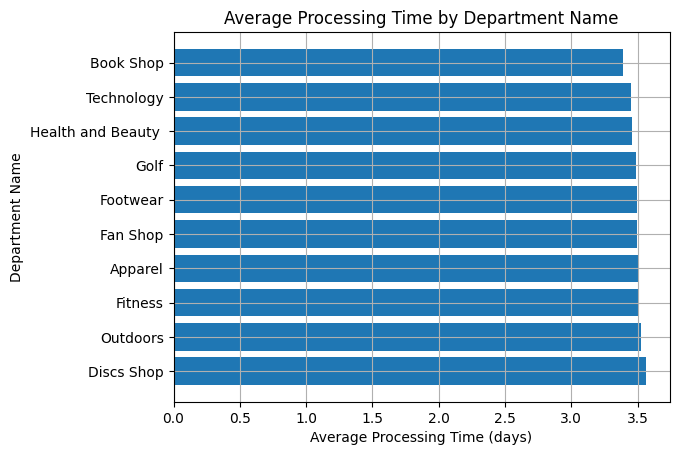

In [80]:
#What products take the longest to process? - Department

# Group by department_name and calculate the average or maximum real_days_for_shipping
department_processing_time = t_data_3_sdf.groupBy('department_name') \
    .agg(avg('processing_time_actual').alias('avg_processing_time'))

# Sort departments based on processing time
department_processing_time = department_processing_time.orderBy('avg_processing_time', ascending=False)

# Select top 10 departments
department_processing_time = department_processing_time.limit(10)

# Convert to Pandas
department_processing_time_df = department_processing_time.toPandas()

#Plot
plt.barh(department_processing_time_df['department_name'], department_processing_time_df['avg_processing_time'])
plt.xlabel('Average Processing Time (days)')
plt.ylabel('Department Name')
plt.title('Average Processing Time by Department Name')
plt.grid(True)
plt.show()

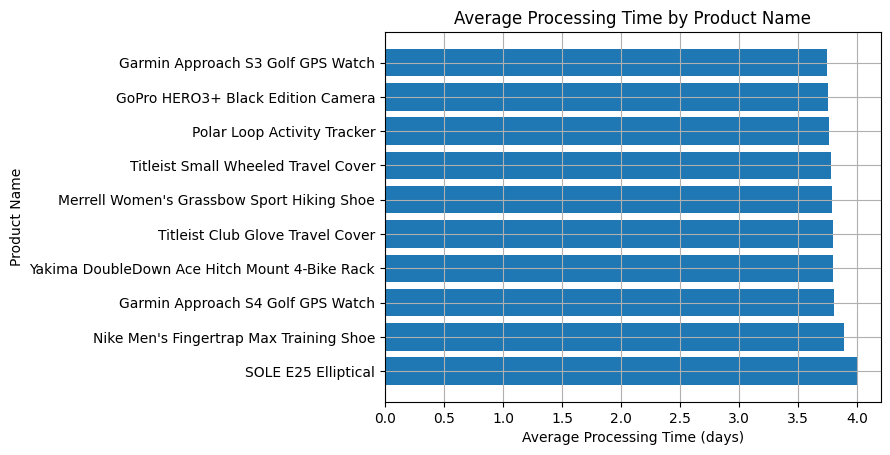

In [81]:
#What products take the longest to process? - Product

# Group by department_name and calculate the average or maximum real_days_for_shipping
department_processing_time = t_data_3_sdf.groupBy('product_name') \
    .agg(avg('processing_time_actual').alias('avg_processing_time'))

# Sort departments based on processing time
department_processing_time = department_processing_time.orderBy('avg_processing_time', ascending=False)

# Select top 5 departments
department_processing_time = department_processing_time.limit(10)

# Convert to Pandas
department_processing_time_df = department_processing_time.toPandas()

# Plot
plt.barh(department_processing_time_df['product_name'], department_processing_time_df['avg_processing_time'])
plt.xlabel('Average Processing Time (days)')
plt.ylabel('Product Name')
plt.title('Average Processing Time by Product Name')
plt.grid(True)
plt.show()

+------------+-------------------+
|weekday_name|late_delivery_count|
+------------+-------------------+
|      Friday|              14303|
|      Sunday|              14300|
|      Monday|              14196|
|    Thursday|              14165|
|    Saturday|              14089|
|   Wednesday|              14011|
|     Tuesday|              13913|
+------------+-------------------+



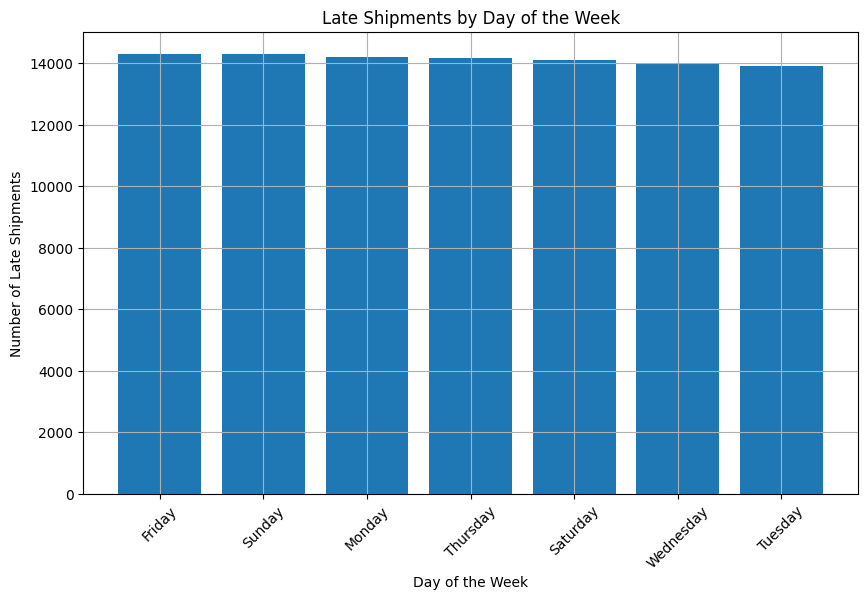

In [82]:
#Numer of late shipments  by day of the week

from pyspark.sql.functions import count, when

#create a weekday_name column
data_3_sdf2 = t_data_3_sdf.withColumn('weekday_name',
                                   when(t_data_3_sdf['order_day'] == 1, 'Sunday')
                                   .when(t_data_3_sdf['order_day'] == 2, 'Monday')
                                   .when(t_data_3_sdf['order_day'] == 3, 'Tuesday')
                                   .when(t_data_3_sdf['order_day'] == 4, 'Wednesday')
                                   .when(t_data_3_sdf['order_day'] == 5, 'Thursday')
                                   .when(t_data_3_sdf['order_day'] == 6, 'Friday')
                                   .when(t_data_3_sdf['order_day'] == 7, 'Saturday')
                                   .otherwise(None))



# Filter the data for late deliveries
late_deliveries = data_3_sdf2.filter(data_3_sdf2['delivery_status'] == 'Late delivery')

# Group by weekday name and count late deliveries and sort descending
weekday_late_counts = late_deliveries.groupBy('weekday_name') \
    .agg(count('*').alias('late_delivery_count'))\
    .orderBy('late_delivery_count', ascending=False)

#View
weekday_late_counts.show()

# Convert to Pandas DataFrame for plotting
weekday_late_counts_df = weekday_late_counts.toPandas()


# Plot the results
plt.figure(figsize=(10, 6))
plt.bar(weekday_late_counts_df['weekday_name'], weekday_late_counts_df['late_delivery_count'])
plt.xlabel('Day of the Week')
plt.ylabel('Number of Late Shipments')
plt.title('Late Shipments by Day of the Week')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

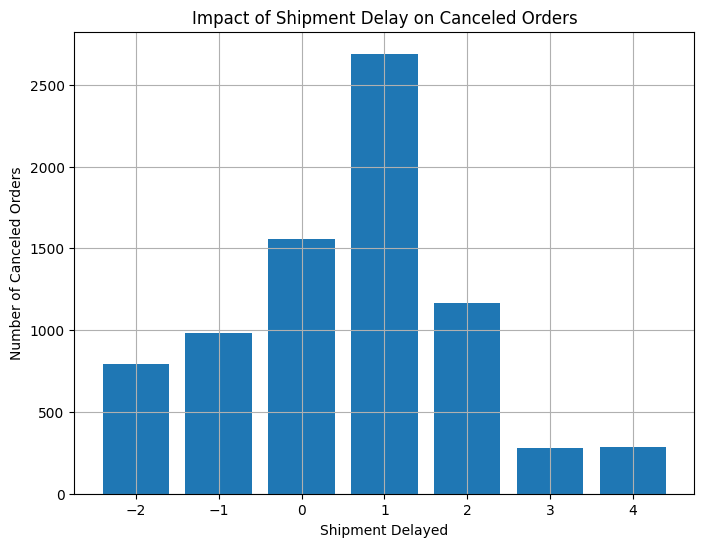

In [83]:
# Filter for rows where delivery_status is 'Shipping canceled'
canceled_orders = data_3_sdf2.filter(data_3_sdf2['delivery_status'] == 'Shipping canceled')

# Group by shipment_delayed and count canceled orders
shipment_delay_impact = canceled_orders.groupBy('delayed_shipment_days') \
    .agg(count('*').alias('canceled_order_count'))

# Convert to Pandas DataFrame for plotting
shipment_delay_impact_df = shipment_delay_impact.toPandas()

# Plot the results
plt.figure(figsize=(8, 6))
plt.bar(shipment_delay_impact_df['delayed_shipment_days'], shipment_delay_impact_df['canceled_order_count'])
plt.xlabel('Shipment Delayed')
plt.ylabel('Number of Canceled Orders')
plt.title('Impact of Shipment Delay on Canceled Orders')
plt.grid(True)
plt.show()


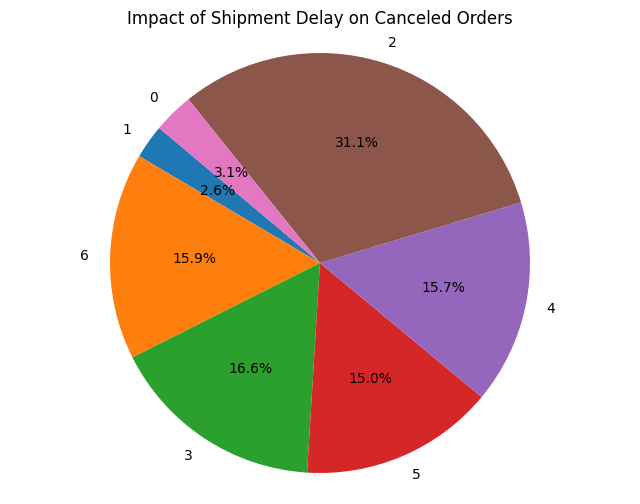

In [84]:
 #Filter for rows where delivery_status is 'Shipping canceled'
canceled_orders = data_3_sdf2.filter(data_3_sdf2['delivery_status'] == 'Shipping canceled')

# Group by shipment_delayed and count canceled orders
shipment_delay_impact = canceled_orders.groupBy('processing_time_actual') \
    .agg(count('*').alias('canceled_order_count')) \
    .withColumn('percentage', (col('canceled_order_count') / canceled_orders.count()) * 100)

# Convert to Pandas DataFrame for plotting
shipment_delay_impact_df = shipment_delay_impact.toPandas()

# Plot the results as a pie chart
plt.figure(figsize=(8, 6))
plt.pie(shipment_delay_impact_df['canceled_order_count'], labels=shipment_delay_impact_df['processing_time_actual'], autopct='%1.1f%%', startangle=140)
plt.title('Impact of Shipment Delay on Canceled Orders')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

+------------+-------------------+
|weekday_name|average_order_count|
+------------+-------------------+
|   Wednesday|            25587.0|
|     Tuesday|            25622.0|
|      Friday|            25925.0|
|    Thursday|            25752.0|
|    Saturday|            25901.0|
|      Monday|            25786.0|
|      Sunday|            25946.0|
+------------+-------------------+



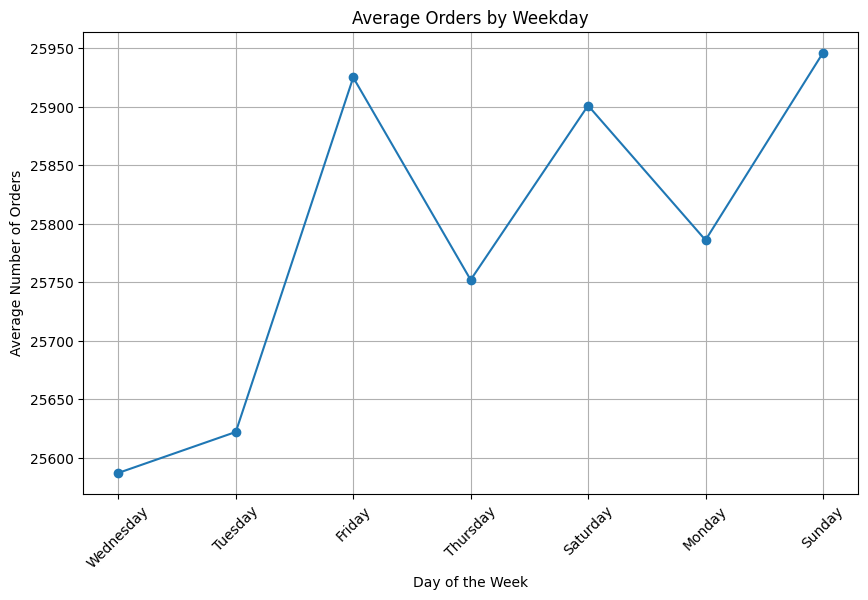

In [85]:
# Assuming you have the DataFrame data_3_sdf2 and the necessary imports already defined

# Group by weekday name and count the number of orders
orders_by_weekday = data_3_sdf2.groupBy('weekday_name') \
    .agg(count('*').alias('order_count'))

# Calculate the average number of orders per weekday
average_orders_by_weekday = orders_by_weekday.groupBy('weekday_name') \
    .agg(avg('order_count').alias('average_order_count'))

average_orders_by_weekday.show()

# Convert to Pandas DataFrame for plotting
average_orders_by_weekday_df = average_orders_by_weekday.toPandas()

# Plot the results as a line chart
plt.figure(figsize=(10, 6))
plt.plot(average_orders_by_weekday_df['weekday_name'], average_orders_by_weekday_df['average_order_count'], marker='o')
plt.xlabel('Day of the Week')
plt.ylabel('Average Number of Orders')
plt.title('Average Orders by Weekday')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

+------------+-------------------+-----------------------+
|weekday_name|average_order_count|average_processing_time|
+------------+-------------------+-----------------------+
|   Wednesday|            25587.0|                    3.5|
|     Tuesday|            25622.0|                    3.5|
|      Friday|            25925.0|                    3.5|
|    Thursday|            25752.0|                    3.5|
|    Saturday|            25901.0|                    3.5|
|      Monday|            25786.0|                    3.5|
|      Sunday|            25946.0|                    3.5|
+------------+-------------------+-----------------------+



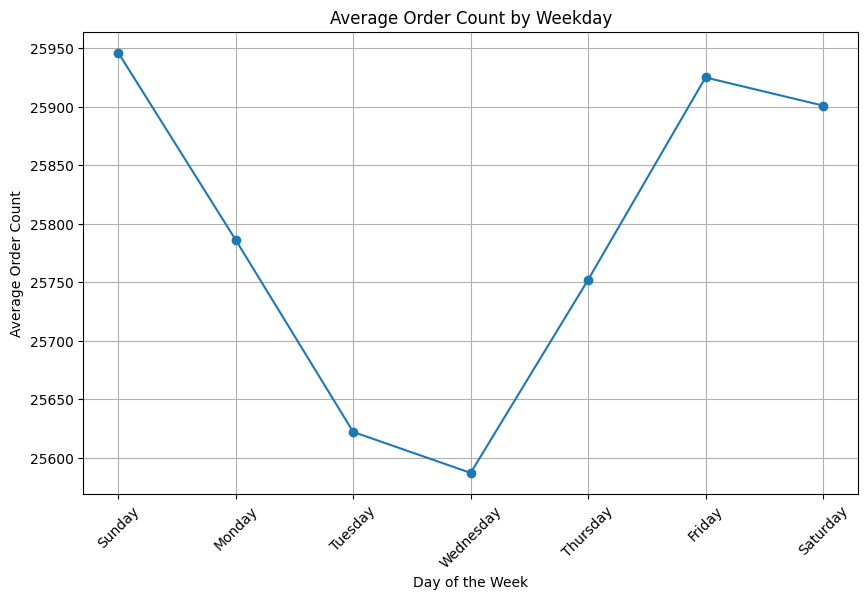

In [86]:
from pyspark.sql.functions import avg, format_number

# Group by weekday name and calculate the average processing time, rounding to the nearest tenth
processing_time_by_weekday = data_3_sdf2.groupBy('weekday_name') \
    .agg(format_number(avg('processing_time_actual'), 1).alias('average_processing_time'))

# Join average_orders_by_weekday with processing_time_by_weekday on 'weekday_name'
average_orders_and_processing_time = average_orders_by_weekday.join(
    processing_time_by_weekday,
    'weekday_name',
    'left_outer'
)

# Show the DataFrame with the added column
average_orders_and_processing_time.show()

average_orders_and_processing_time_pd = average_orders_by_weekday.toPandas()

# Define the correct order of weekday names starting with Sunday
correct_order = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']

# Sort the Pandas DataFrame by the correct order of weekday names
average_orders_and_processing_time_pd['weekday_name'] = pd.Categorical(average_orders_and_processing_time_pd['weekday_name'], categories=correct_order, ordered=True)
average_orders_and_processing_time_pd.sort_values('weekday_name', inplace=True)

# Plot the data on a line chart
plt.figure(figsize=(10, 6))
plt.plot(average_orders_and_processing_time_pd['weekday_name'], average_orders_and_processing_time_pd['average_order_count'], marker='o')
plt.xlabel('Day of the Week')
plt.ylabel('Average Order Count')
plt.title('Average Order Count by Weekday')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

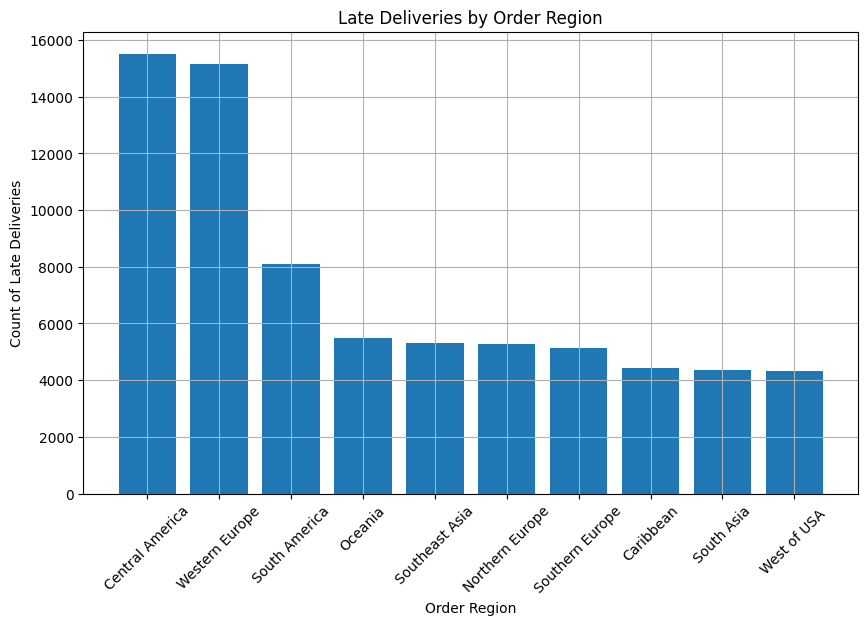

In [87]:
# Filter the DataFrame for rows where delivery_status is 'Late delivery'
late_deliveries = data_3_sdf2.filter(data_3_sdf2['delivery_status'] == 'Late delivery')

# Group by order_region and count late deliveries
late_deliveries_by_region = late_deliveries.groupBy('order_region').count()

late_deliveries_by_region = late_deliveries_by_region.orderBy('count', ascending=False).limit(10)

# Convert DataFrame to Pandas DataFrame for plotting
late_deliveries_by_region_pd = late_deliveries_by_region.toPandas()

# Plot the results
plt.figure(figsize=(10, 6))
plt.bar(late_deliveries_by_region_pd['order_region'], late_deliveries_by_region_pd['count'])
plt.xlabel('Order Region')
plt.ylabel('Count of Late Deliveries')
plt.title('Late Deliveries by Order Region')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

---

---
---
---

---